In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import glob
sys.path.append('..')
from plot_helpers import *
import warnings
warnings.filterwarnings('ignore')

In [4]:
comps = {
    'different subgrid forcings': dict(
        fullycnn2=dict(
            label="$S_q = \\overline{\\left(\\mathbf{u} \\cdot \\nabla\\right)q} - \\left(\\overline{\\mathbf{u}} \\cdot \\nabla\\right)\\overline{q}$",
        ),
        fullycnn_way2=dict(
            label="$S_q = \\overline{\\left(\\mathbf{u} \\cdot \\nabla\\right)q} - \\left(\\overline{\\mathbf{u}} \\cdot \\nabla\\right)\\overline{q} + \\overline{F_{diss}^{hires}} - F_{diss}^{lores}$",
        ),
    ),
    'different input features': dict(
        fullycnn=dict(
            label="Use $q,u,v$ to predict $S_q$",
        ),
        fullycnn_uv_only=dict(
            label="Just use $u$ and $v$"
        ),
        fullycnn_q_only=dict(
            label="Just use $q$"
        ),
        fullycnn_dqdt=dict(
            label="Use $dq/dt$"
        )
    ),
    "different data scalings": dict(
        fullycnn=dict(
            label="Uniform $z$-scoring"
        ),
        fullycnn_rescale_loss=dict(
            label="Rescale inputs and outputs to\n$\\sigma_{new}$ = 1 / (1+ |log $\\sigma_{old}$ - max log $\\sigma_{old}$|)"
        )
    ),
    "different dataset sizes": {
        "fullycnn_skip_0.0": dict(
           label='100% data',
           color='black'
        ),
        'fullycnn_skip_0.9': dict(
            label='10% data',
            color=(0.5,0.5,0.5),
            ls='--'
        ),
        'fullycnn_skip_0.99': dict(
            label='1% data',
            color=(0.83, 0.83, 0.83),
            ls=':'
        )
    }
}

In [5]:
def compare_offline_performance(label, model_opts, model_dir="/scratch/zanna/data/pyqg/models"):
    models = list(sorted(model_opts.keys()))
    preds = {}
    for m in models:
        preds[m] = xr.open_mfdataset(f"{model_dir}/{m}/0/test/*/preds.nc", combine="nested", concat_dim="run")
        
    with figure_grid(1,2,rowheight=4) as g:
        g.title(f"Correlation of predictions wrt. forcing, {label}", y=0.95)
        for z in range(2):
            g.next()
            for m in sorted(models):
                preds[m].correlation.isel(lev=z).mean(dim='run').plot(lw=4, **model_opts[m])
            if z==0: plt.legend(fontsize=12)
            plt.title(f"{['Upper','Lower'][z]} Layer", fontsize=14)
            plt.ylabel("Correlation with $S_q$", fontsize=14)
            plt.xlabel("Simulation time (s)", fontsize=14),
            plt.xlim(0,1.5e17)
            
    with figure_grid(1,2,rowheight=4) as g:
        g.title(f"MSE of predictions wrt. forcing, second half, {label}", y=0.95)
        for z in range(2):
            g.next()
            for m in models:
                preds[m].mean_sq_err.isel(lev=z).mean(dim='run').plot(lw=4, **model_opts[m])
            if z == 0: plt.legend(fontsize=12)
            plt.yscale('log')
            plt.title(f"{['Upper','Lower'][z]} Layer", fontsize=14)
            plt.ylabel("MSE", fontsize=14)
            plt.xlabel("Simulation time (s)", fontsize=14)
            plt.xlim(0,1.5e17)

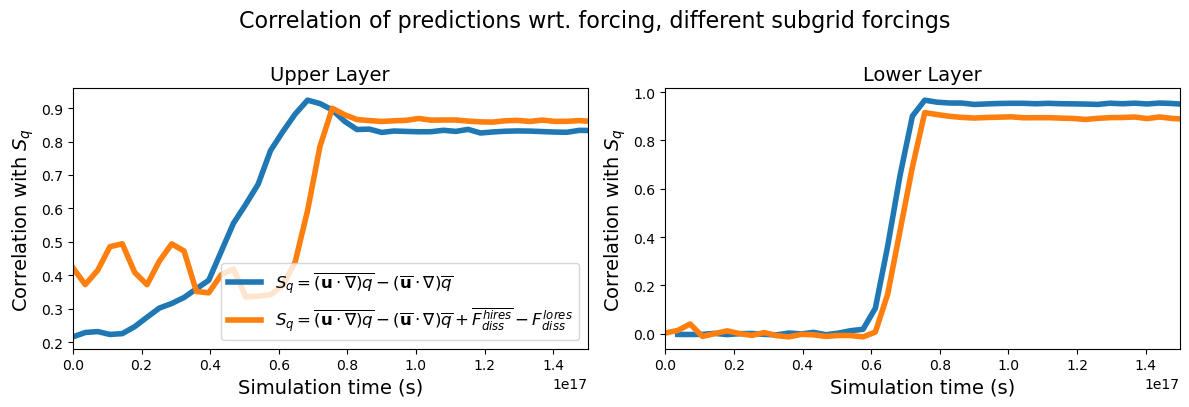

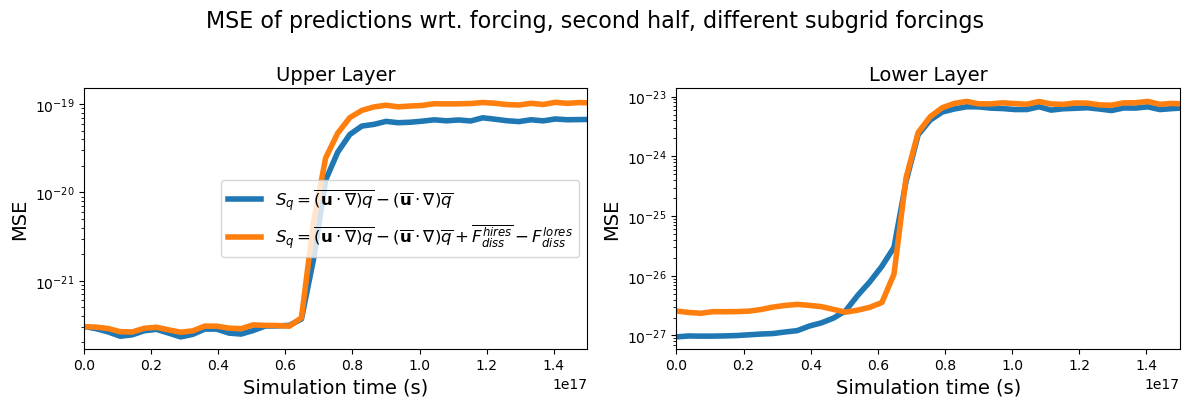

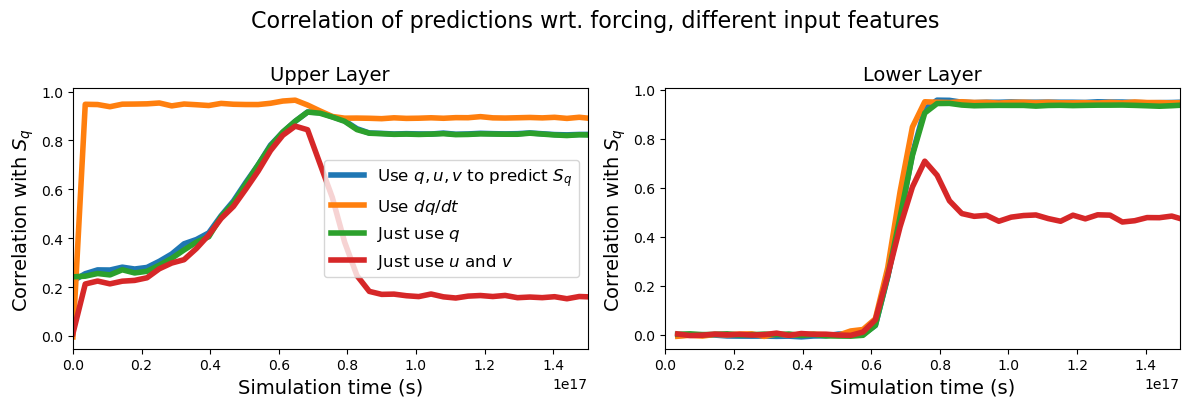

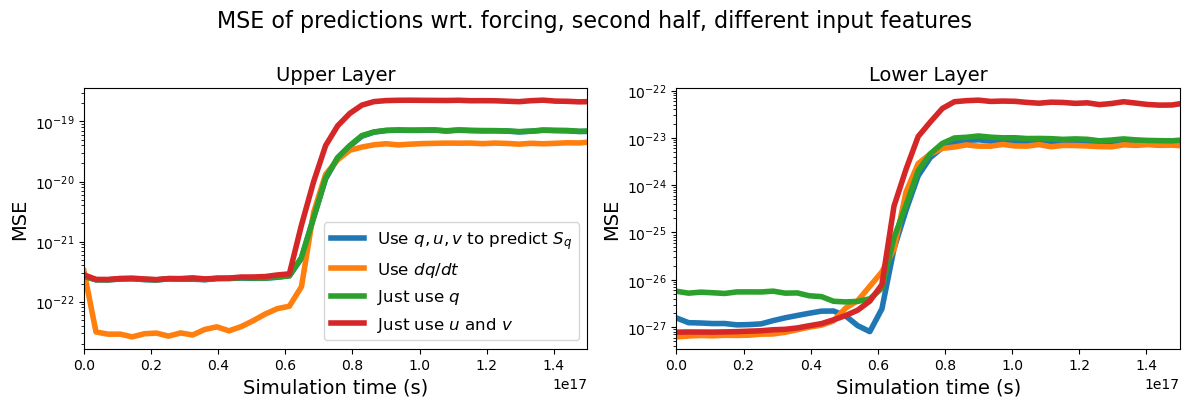

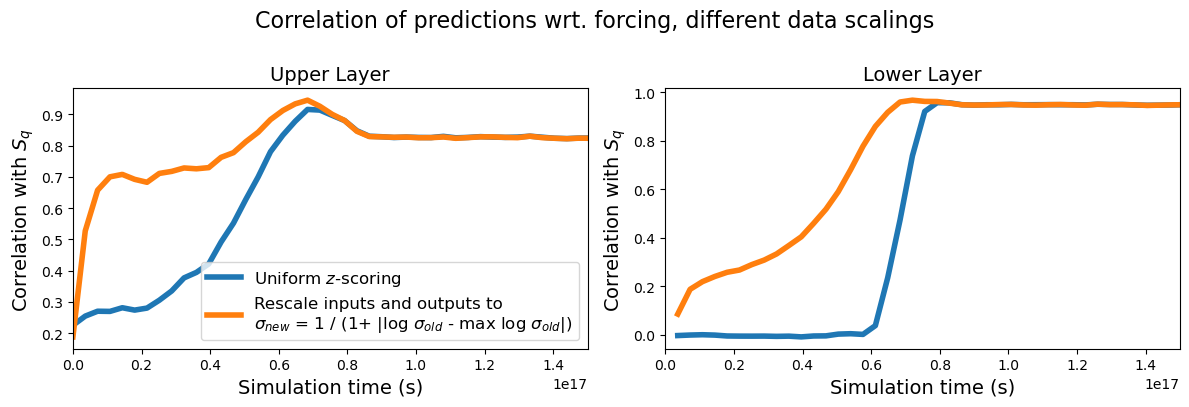

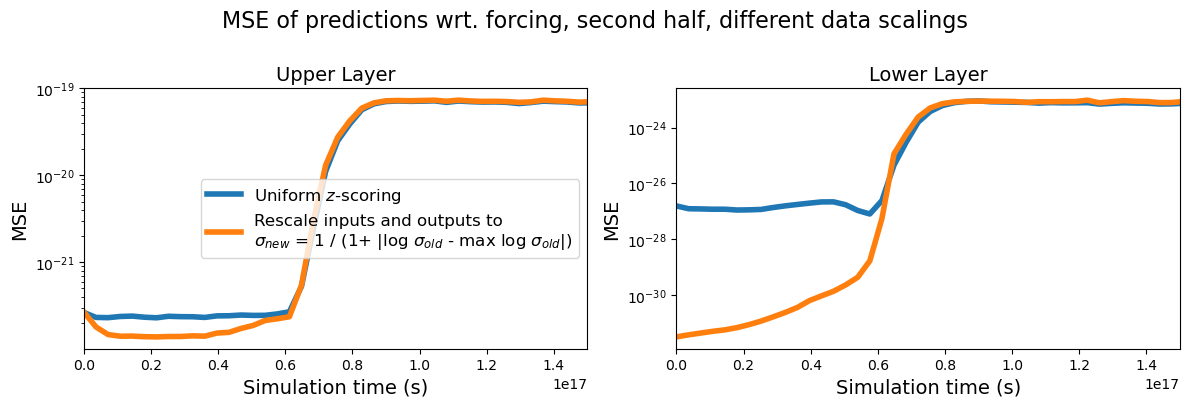

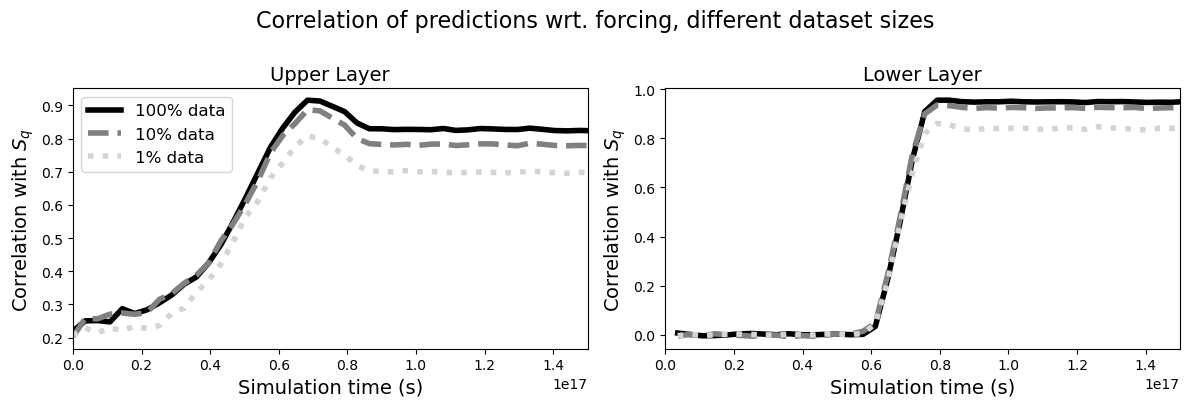

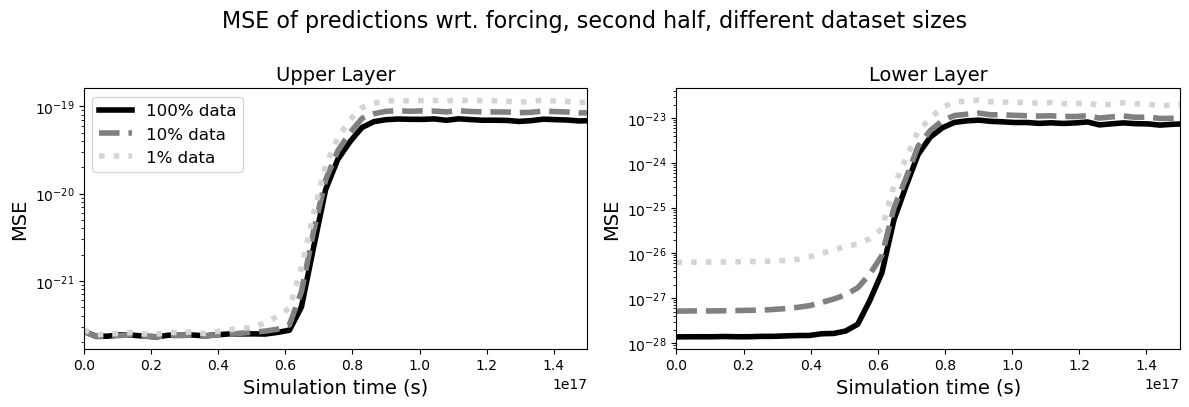

In [6]:
for label, model_opts in comps.items():
    compare_offline_performance(label, model_opts)

In [45]:
run_cache = {}

In [89]:
def get_parameterized_runs(key, ps, model_dir="/scratch/zanna/data/pyqg/models"):
    if (key, ps, model_dir) not in run_cache:
        run_cache[(key, ps, model_dir)] = xr.concat(
            [xr.open_dataset(f) for f in glob.glob(f"{model_dir}/{key}/*/pyqg_runs/paramsets/{ps}/*.nc")], "run"
        )
    return run_cache[(key, ps, model_dir)]
    
def get_normal_runs(key, data_dir="/scratch/zanna/data/pyqg/datasets/test", n_runs=25):
    if (key, data_dir) not in run_cache:
        run_cache[(key,data_dir)] = xr.concat(
            [xr.open_dataset(f"{data_dir}/{n}/{key}.nc") for n in range(n_runs)], "run"
        )
    return run_cache[(key,data_dir)]

def compare_online_performance(label, model_opts,                     
        model_dir="/scratch/zanna/data/pyqg/models",
        data_dir="/scratch/zanna/data/pyqg/datasets/test",
        show_physical=False
    ):
    
    runs = []
    
    ps = 1 if 'transfer' in data_dir else 0
    
    from collections import OrderedDict
    if isinstance(model_opts, OrderedDict):
        models = list(model_opts.keys())
    else:
        models = list(sorted(model_opts.keys()))
    
    for m in models:
        runs.append(get_parameterized_runs(m, ps, model_dir).assign_attrs(plot_kwargs=model_opts[m]))
        
    lores = get_normal_runs("control", data_dir).assign_attrs(plot_kwargs=dict(label='Lo-res', color='darkgoldenrod', ls='--'))
    hires = get_normal_runs("lores", data_dir).assign_attrs(plot_kwargs=dict(label='Hi-res (downscaled)', color='darkgoldenrod'))

    runs += [lores, hires]
    
    if show_physical:
        runs.append(get_normal_runs("physical", data_dir).assign_attrs(plot_kwargs=dict(label='Physical Param.', color='gray')))

    with figure_grid(2, len(runs), rowwidth=len(runs)*4, rowheight=3.75) as g:
        g.title(f"Final potential vorticity values, {label}", y=0.95, fontsize=20)
        for z, layer in zip([0,1], ['upper','lower']):
            for run in runs:
                g.next()
                run.q.isel(time=-1, lev=z, run=-1).plot(cbar_kwargs=dict(label='$q_'+str(z+1)+'$'))
                plt.title(f"{run.attrs['plot_kwargs']['label']}\n{layer} layer", fontsize=14)
                plt.xlabel('x'); plt.xticks([])
                plt.ylabel('y'); plt.yticks([])    
    
    with figure_grid(1,2,rowheight=6) as g:
        g.title(f"Spectra averaged across repeated simulations, {label}", y=0.95)
        g.next()
        plot_spectra('KEspec', runs, z='sum')
        plt.title("Kinetic Energy", fontsize=14)
        g.next()
        plot_spectra('entspec', runs, leg=False)
        plt.title("Enstrophy", fontsize=14)
        
    #with figure_grid(1,2,rowheight=6) as g:
    #    g.title(f"Spectra averaged across repeated simulations, {label}", y=0.95)
    #    g.next()
    #    plot_spectra('KEspec', runs, z=0)
    #    plt.title("Kinetic Energy (upper)", fontsize=14)
    #    g.next()
    #    plot_spectra('KEspec', runs, z=1, leg=False)
    #    plt.title("Kinetic Energy (lower)", fontsize=14)

    from scipy.stats import gaussian_kde, wasserstein_distance
        
    quants = ['u','v','q']
    quants += [
        f"KEspec @ k={k:.2e}" for k in np.logspace(-5,-4,4)]
    with figure_grid(4,len(quants),rowwidth=18) as g:

        for z in [0,1]:
            for q in quants:
                lines = []
                labels = []
                g.next(f"{q},\n{['upper','lower'][z]}".replace(' @ ', "\n"))
                
                def data_for(r):
                    if '@ k=' in q:
                        spec, k = q.split(' @ k=')
                        k = float(k)
                        specs = []
                        for i in r.run:
                            ks, ss = power_spectrum(spec, r.isel(run=i), z=z)
                            specs.append(ss[np.argmin(np.abs(ks-k))])
                        return np.array(specs)
                    else:
                        return r.isel(lev=z, time=-1)[q].data.ravel()
                
                for r in runs:                    
                    data = data_for(r)
                    lo, hi = np.percentile(data, [1,99])
                    diff = (hi-lo)
                    lims = np.linspace(lo - diff*0.25, hi + diff*0.25, 200)
                    kde = gaussian_kde(data)
                    lines.append(plt.plot(lims, kde(lims), lw=3, **r.attrs['plot_kwargs']))
                    labels.append(r.attrs['plot_kwargs']['label'])
                    plt.yticks([])
                    
            plt.legend(loc='center', fontsize=8)
            
            
            for q in quants:
                bars = []
                labels = []
                
                g.next("Dist. to hires")
                hires_data = data_for(hires)
                comps = [r for r in runs if r.attrs['plot_kwargs']['label'] != hires.attrs['plot_kwargs']['label']]
                for i,r in enumerate(comps):
                    run_data = data_for(r)
                    kw = dict(r.attrs['plot_kwargs'])
                    if 'ls' in kw:
                        del kw['ls']
                    plt.bar([i], [wasserstein_distance(hires_data, run_data)], **kw)
                plt.xticks([])
                
            plt.legend(loc='center', fontsize=8)

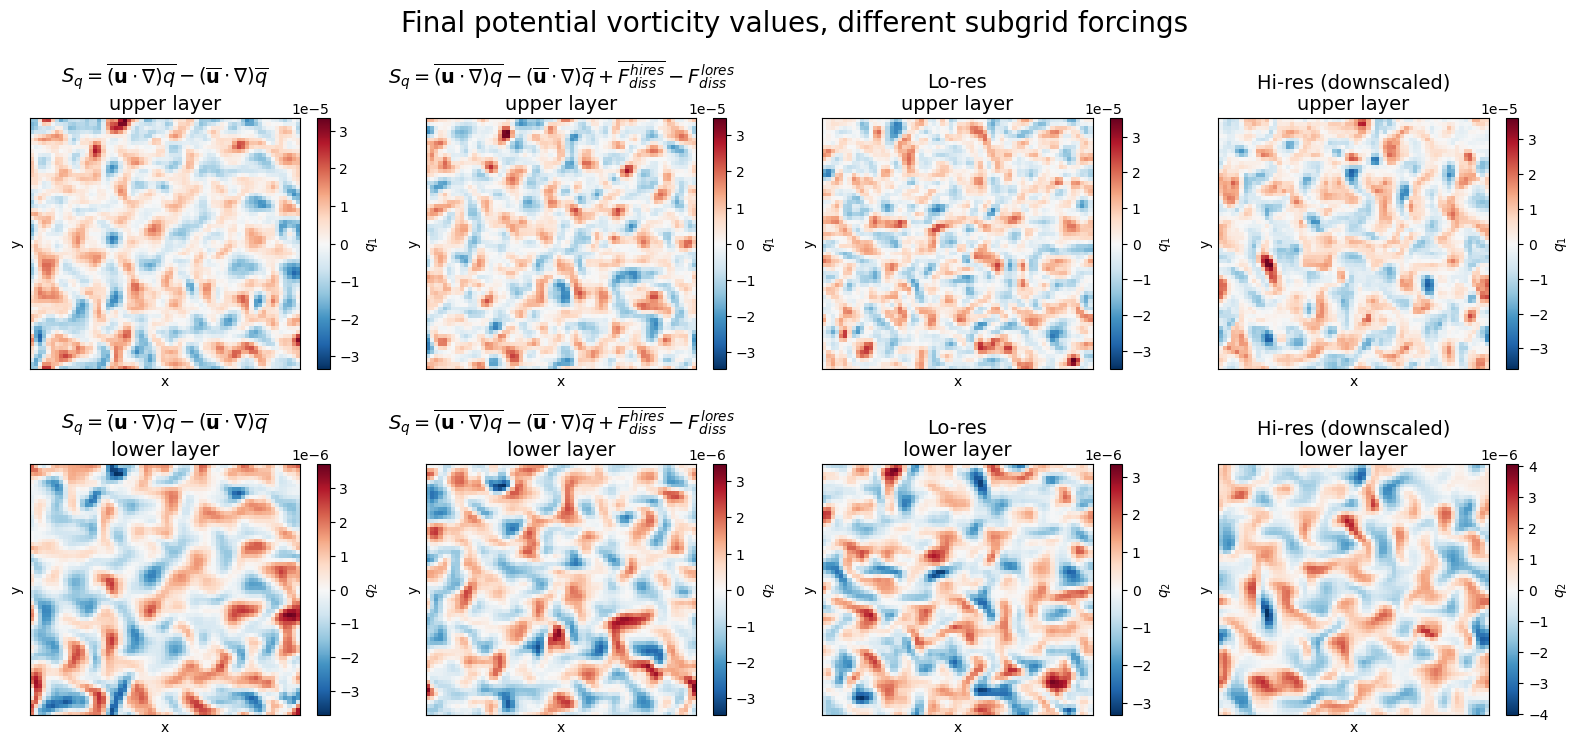

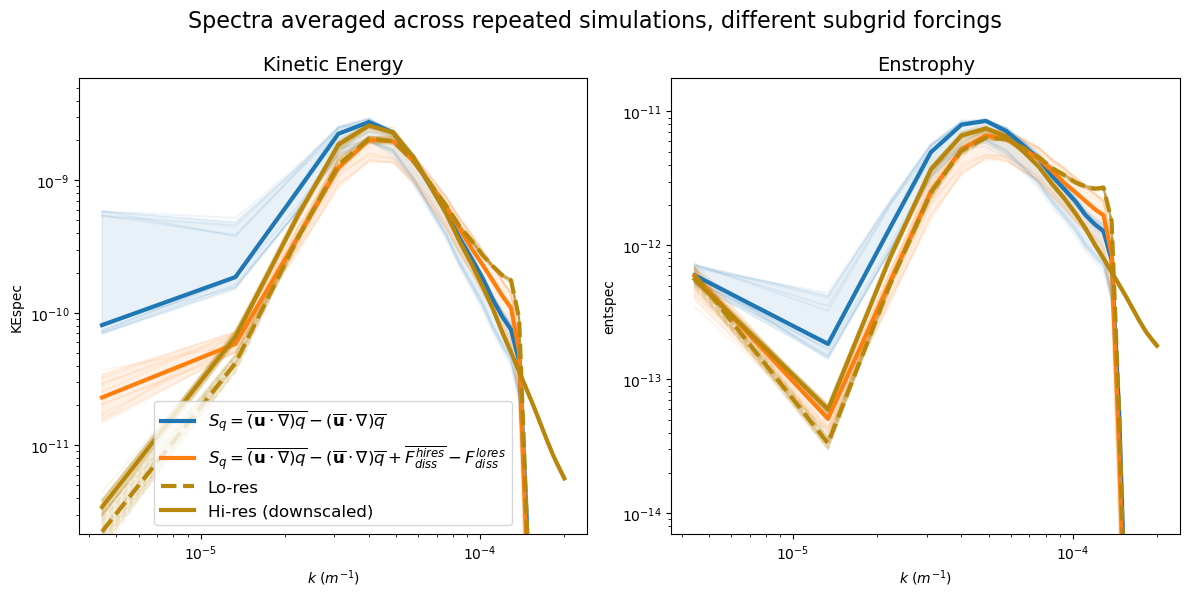

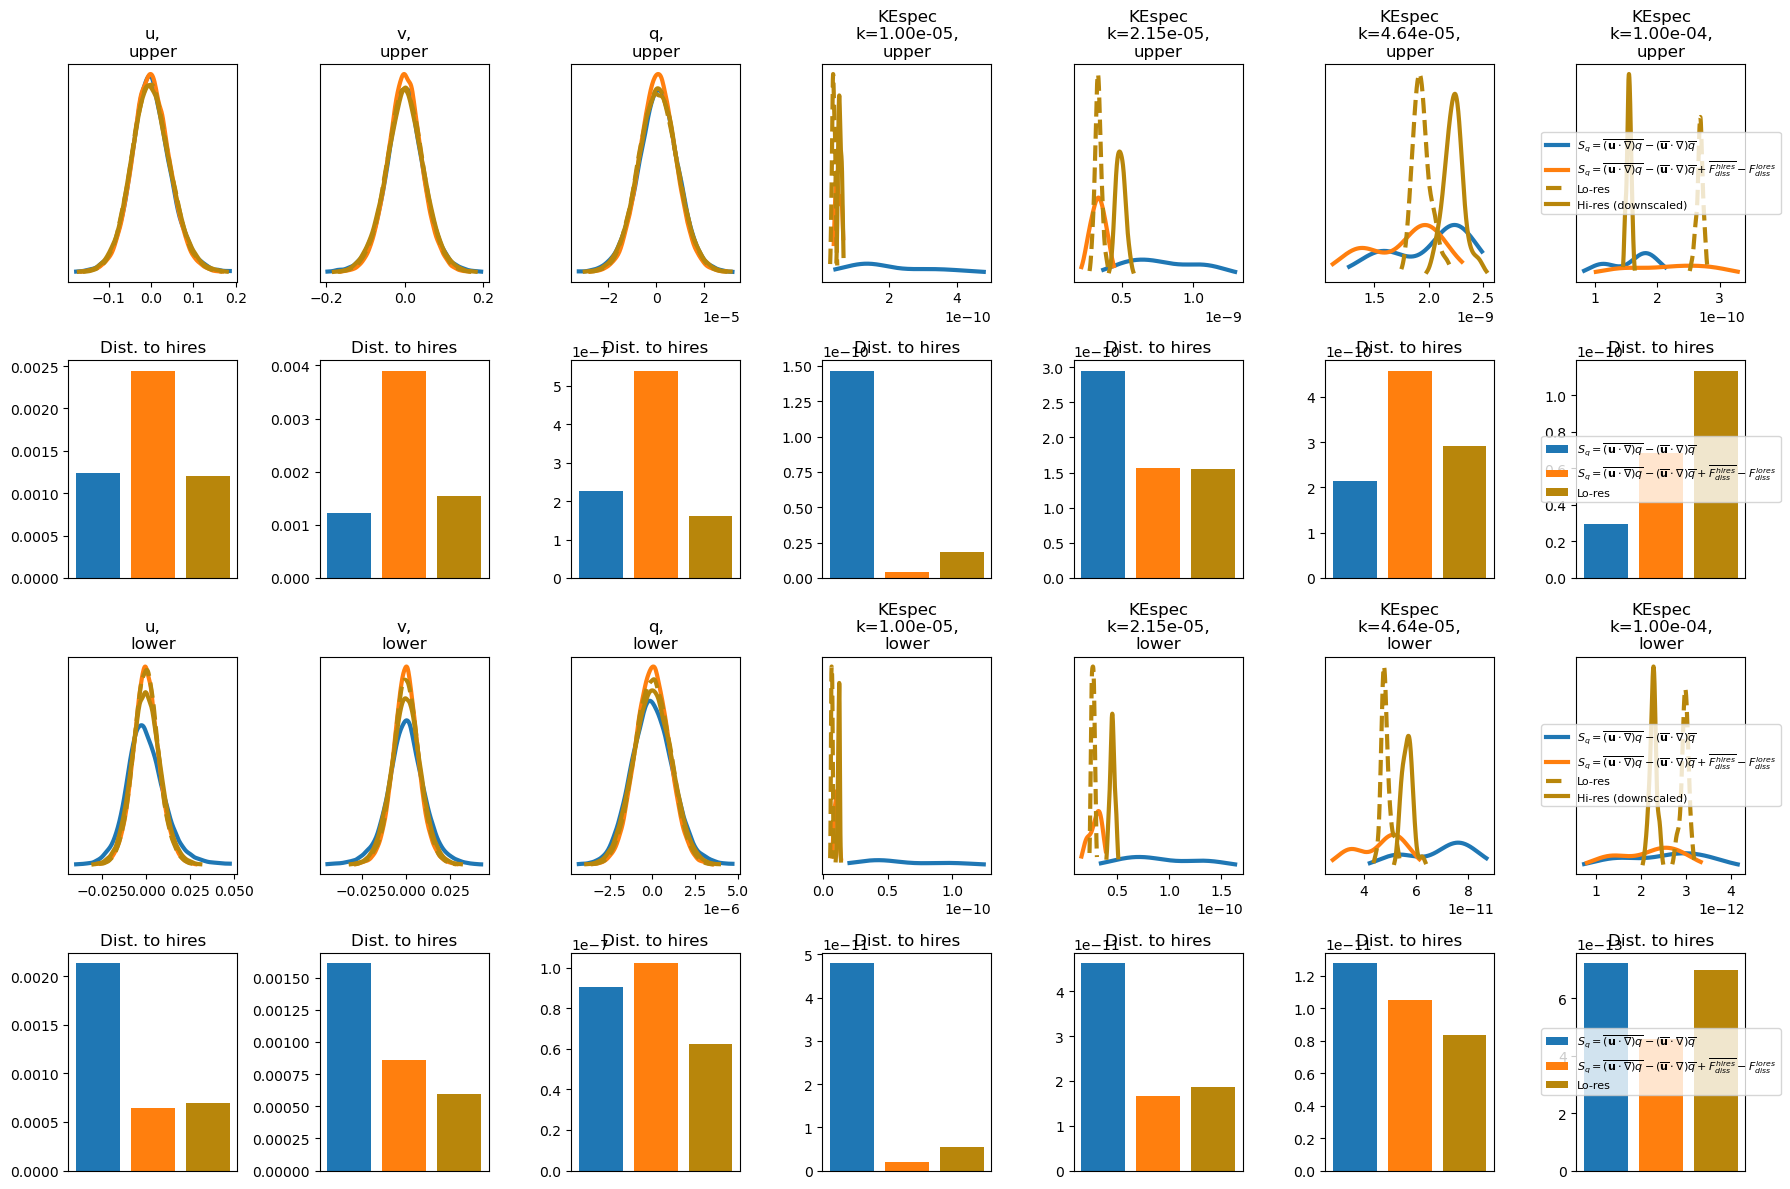

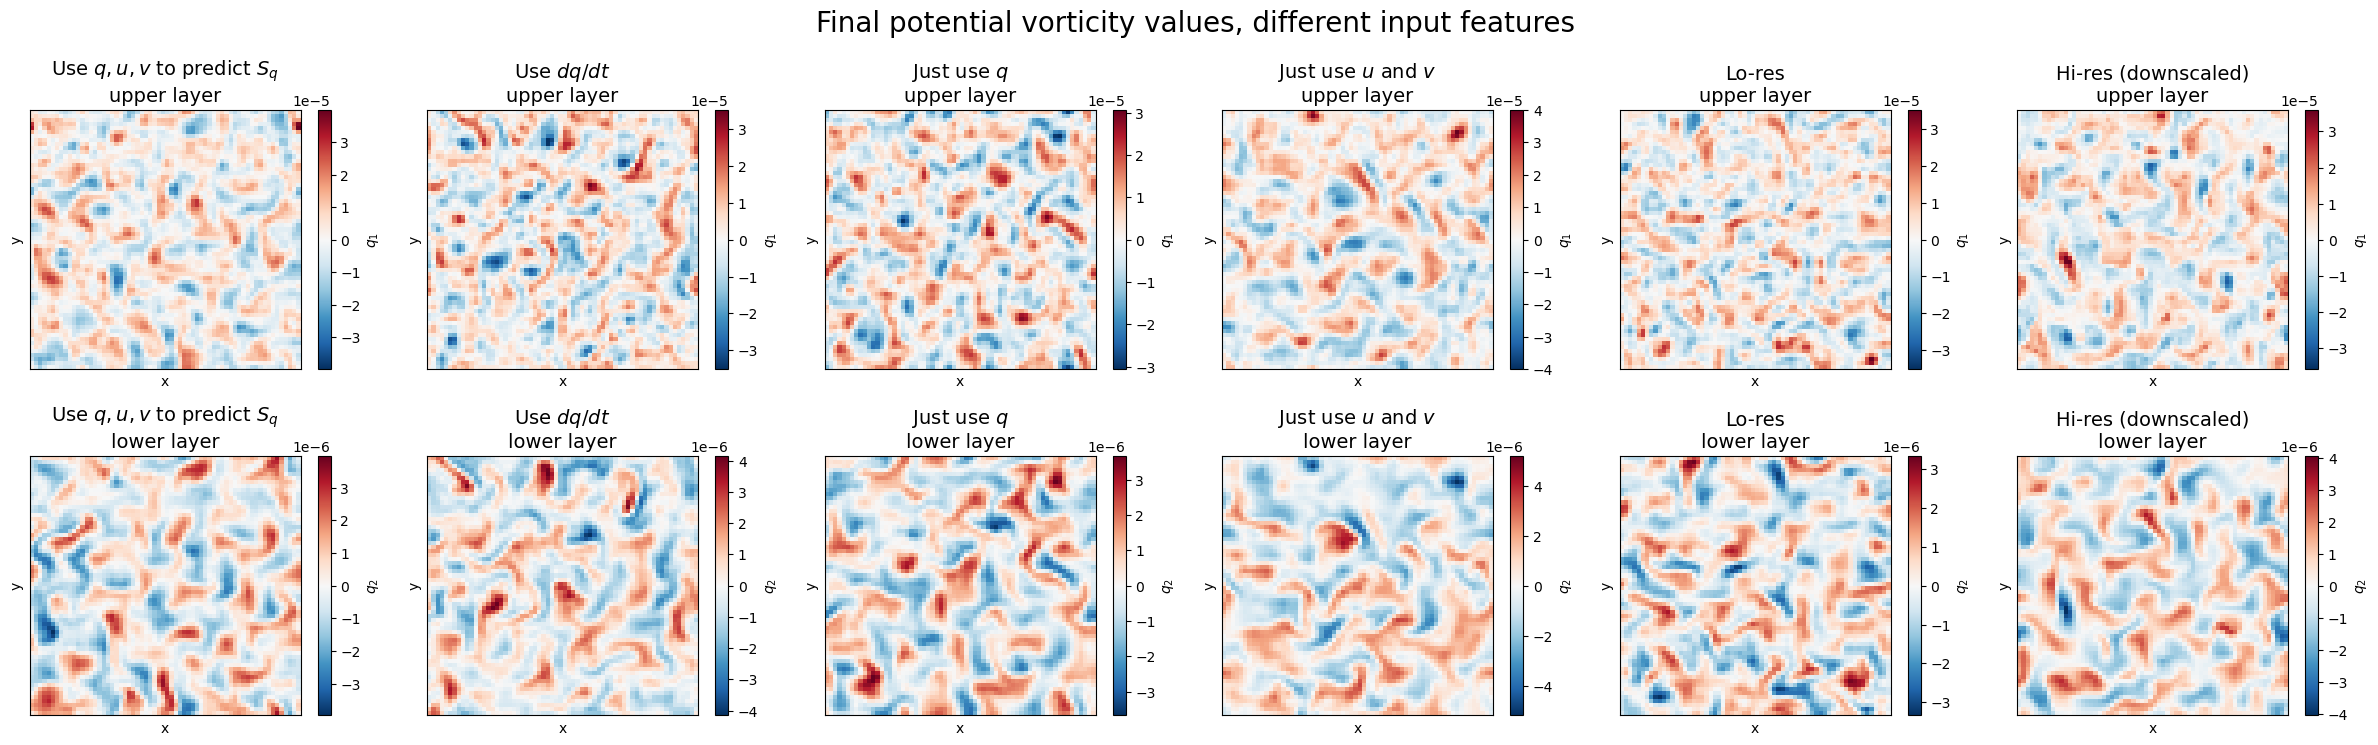

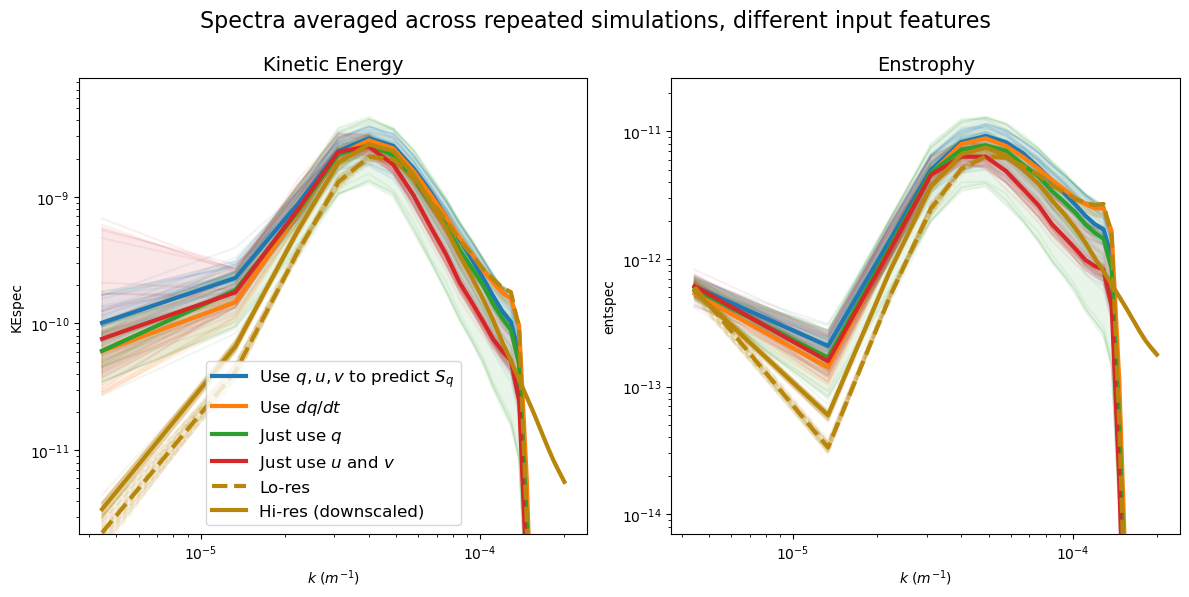

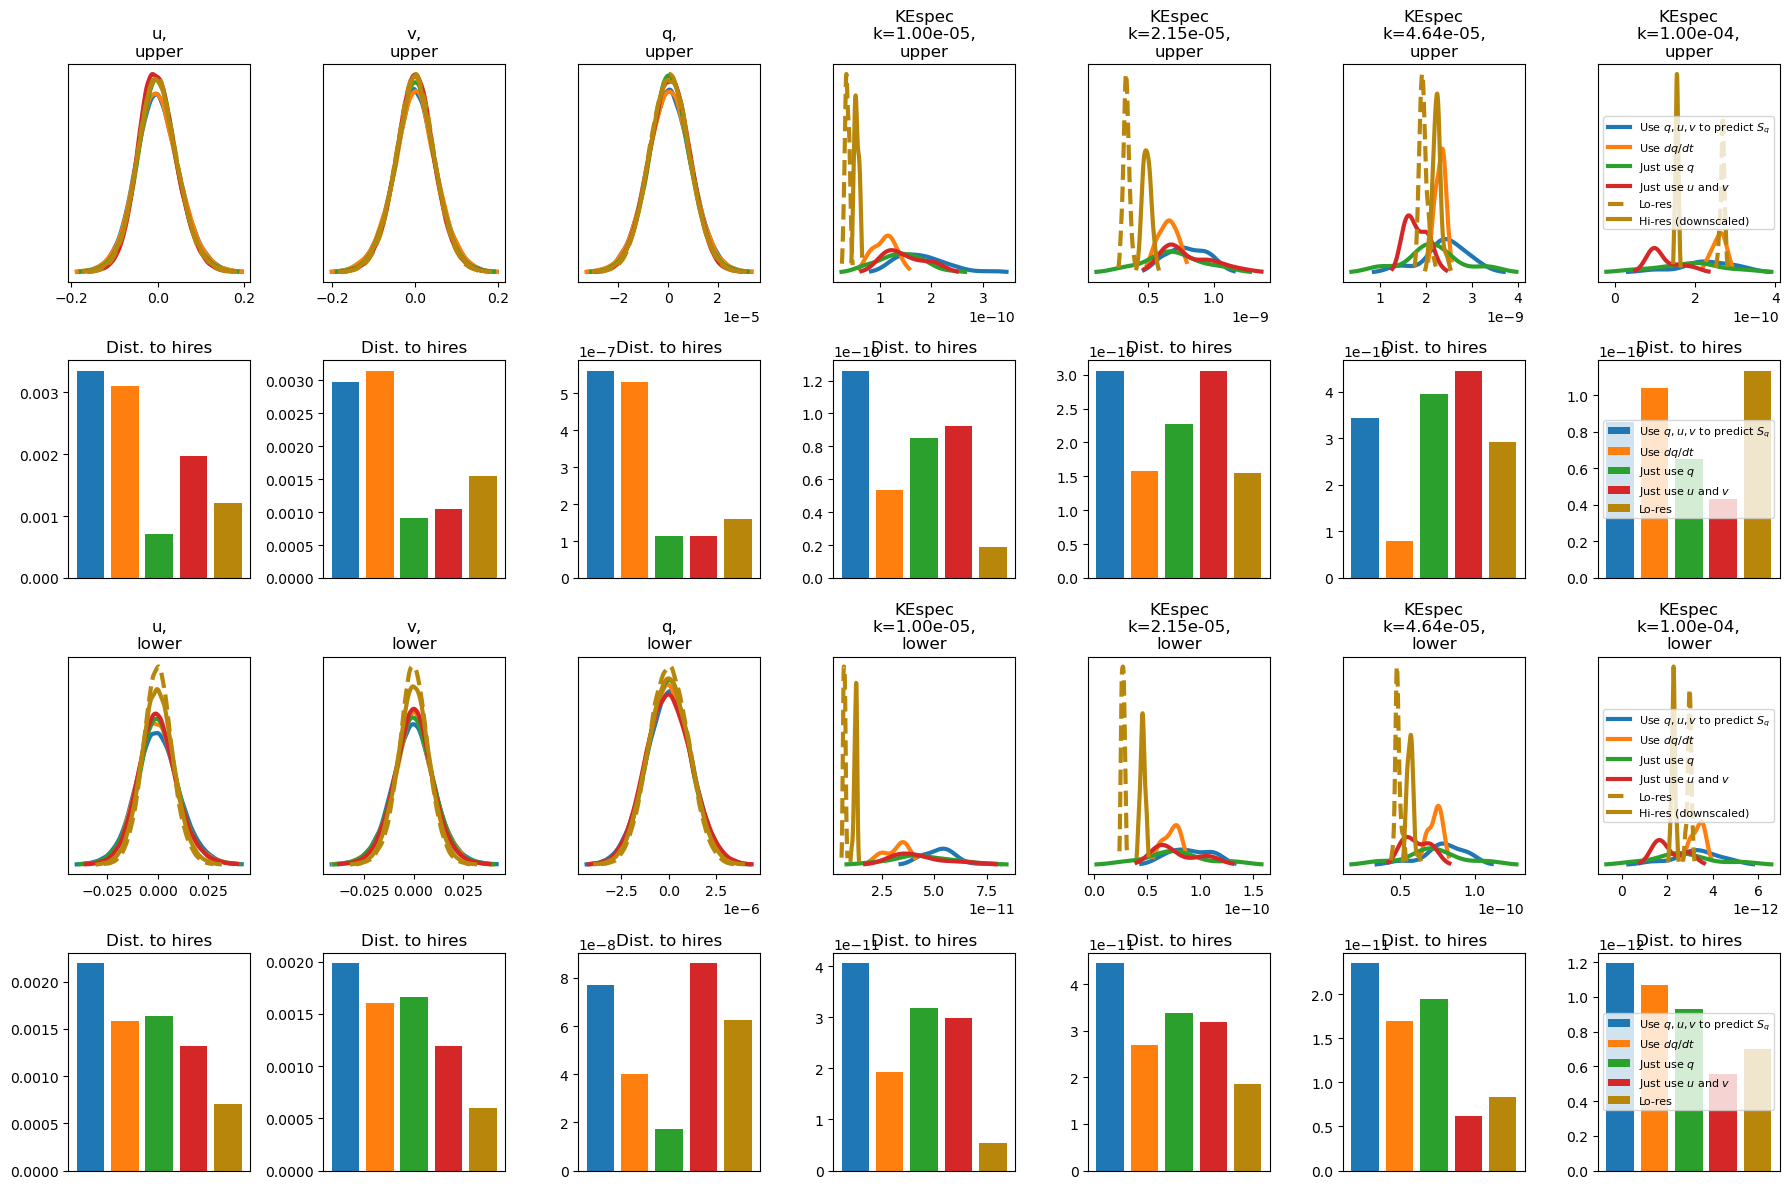

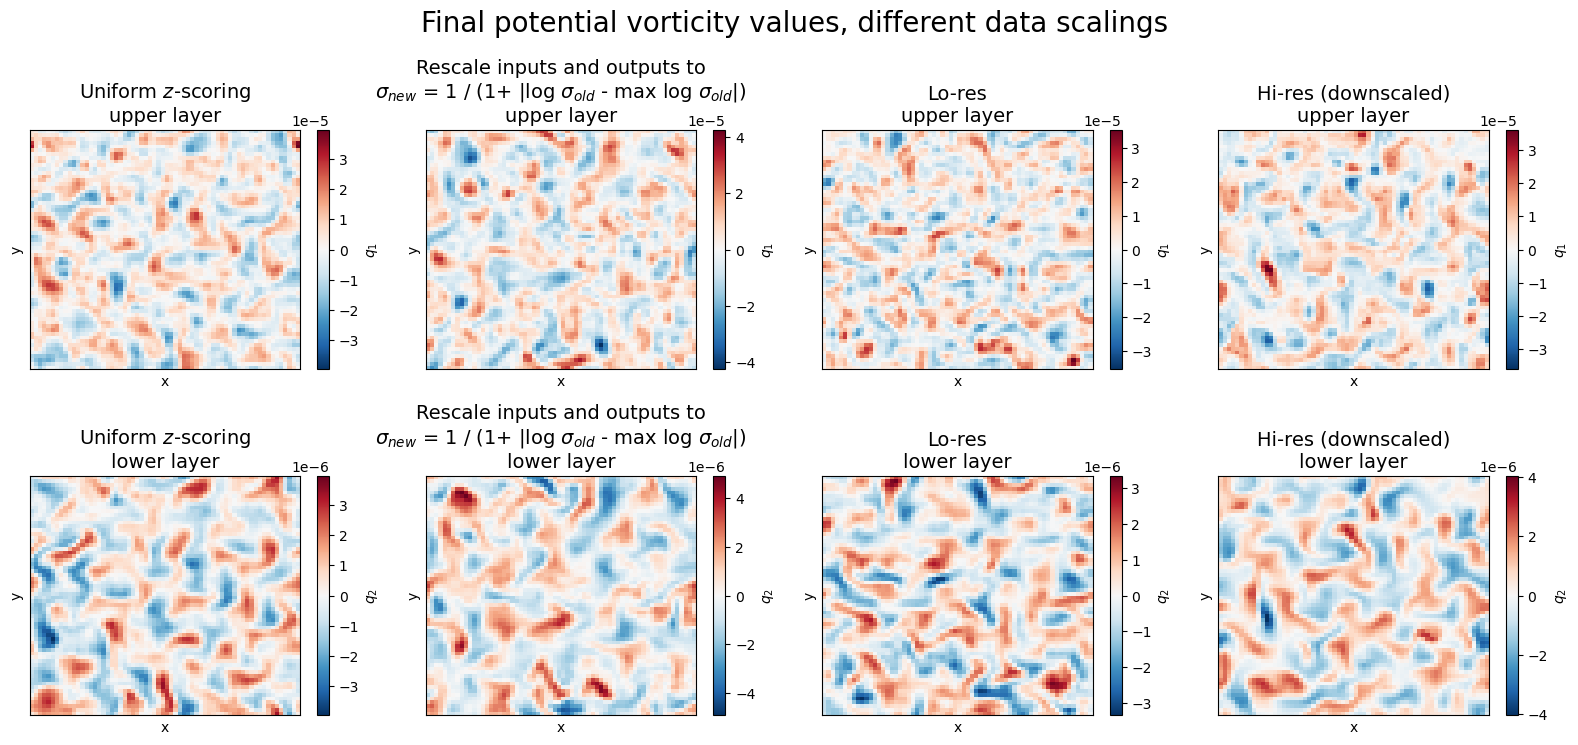

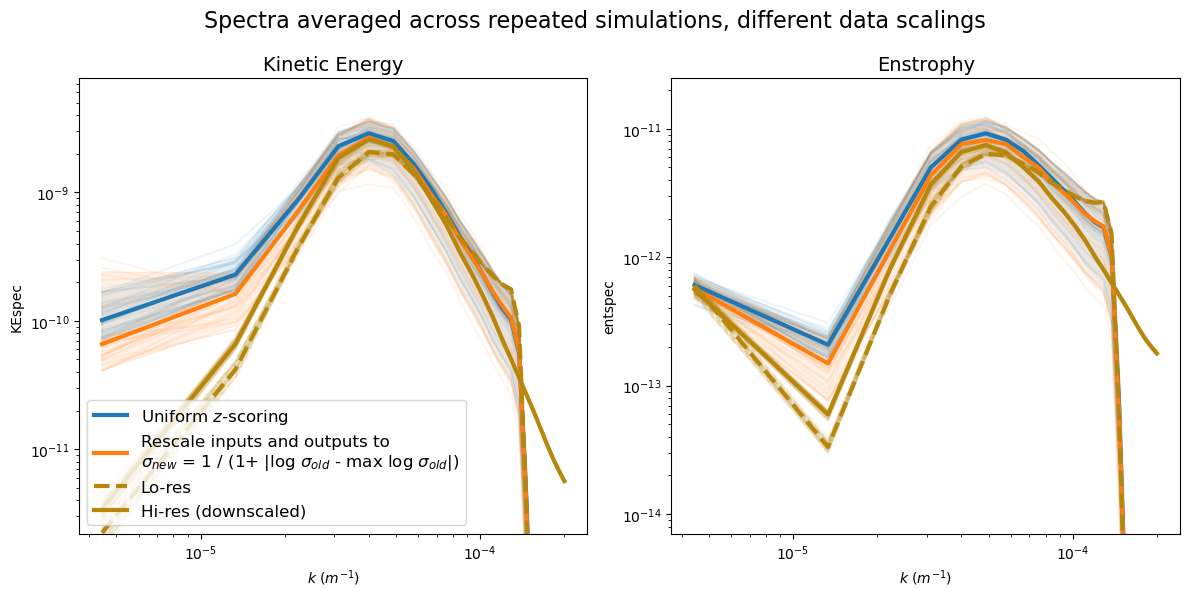

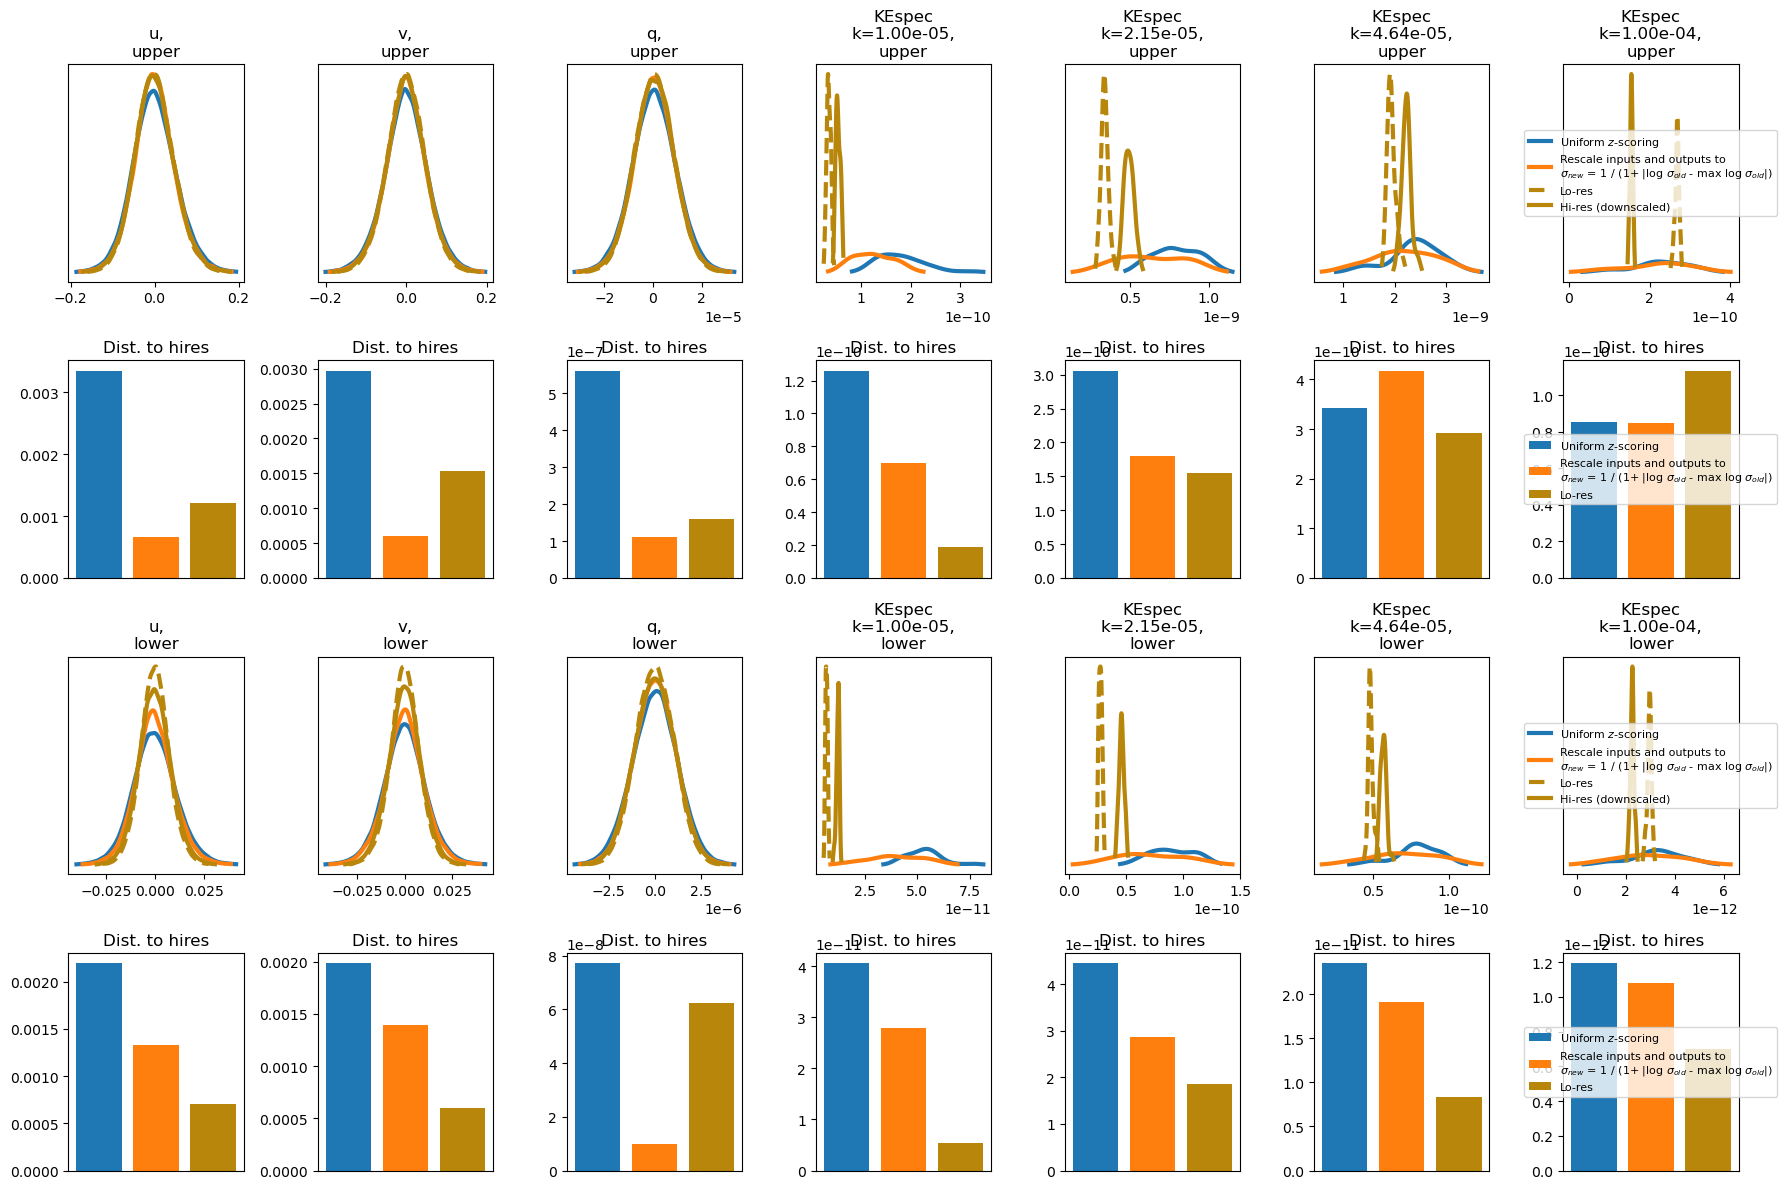

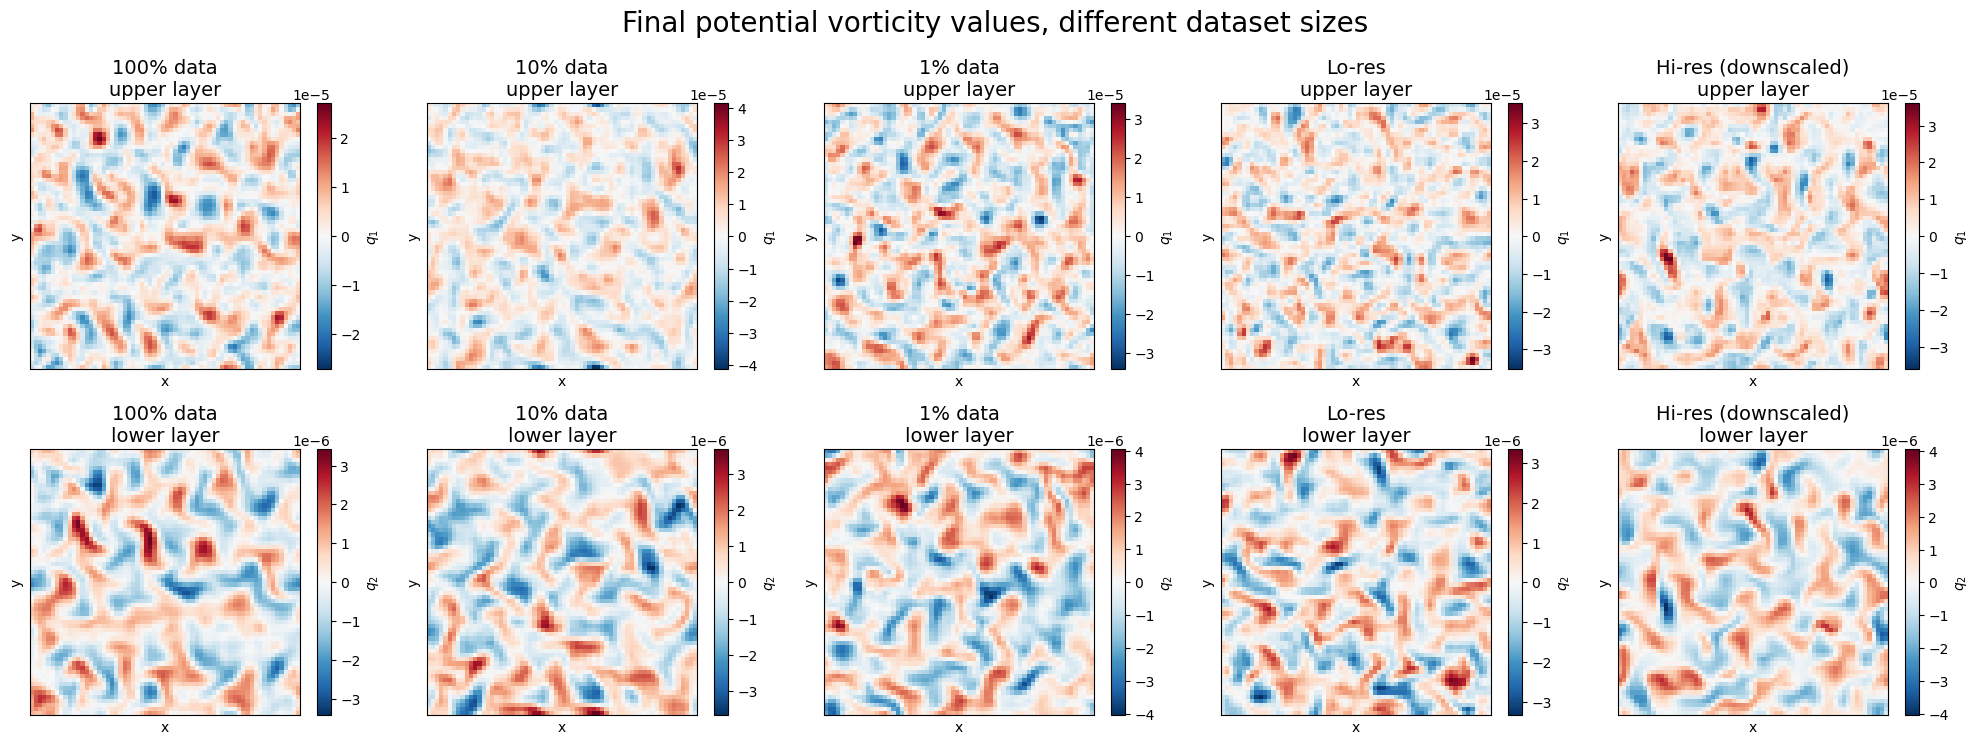

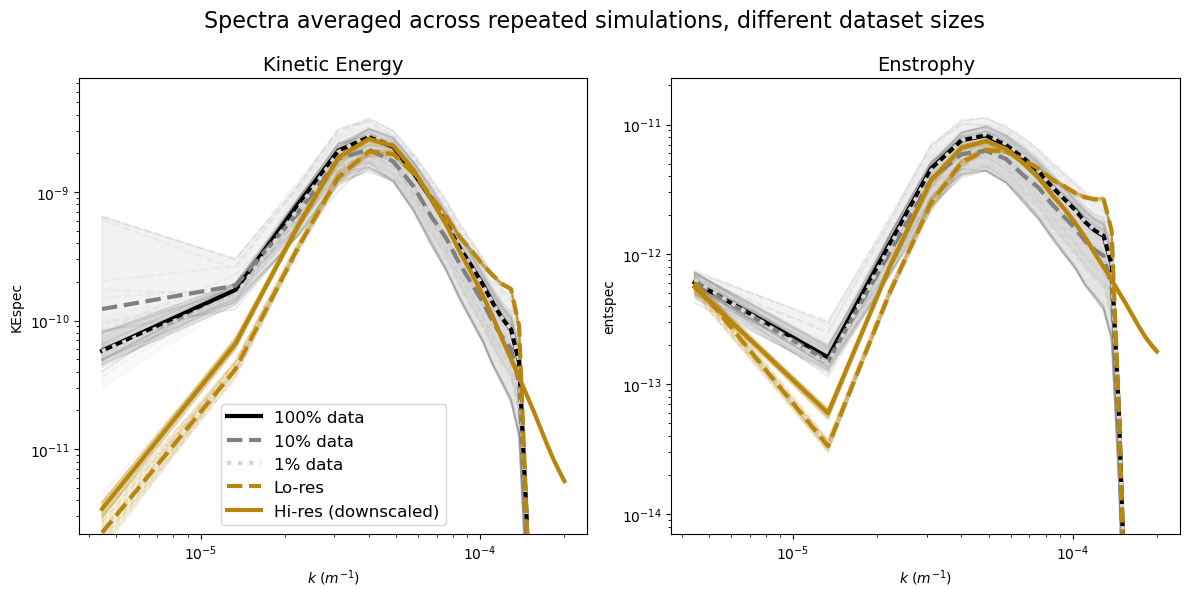

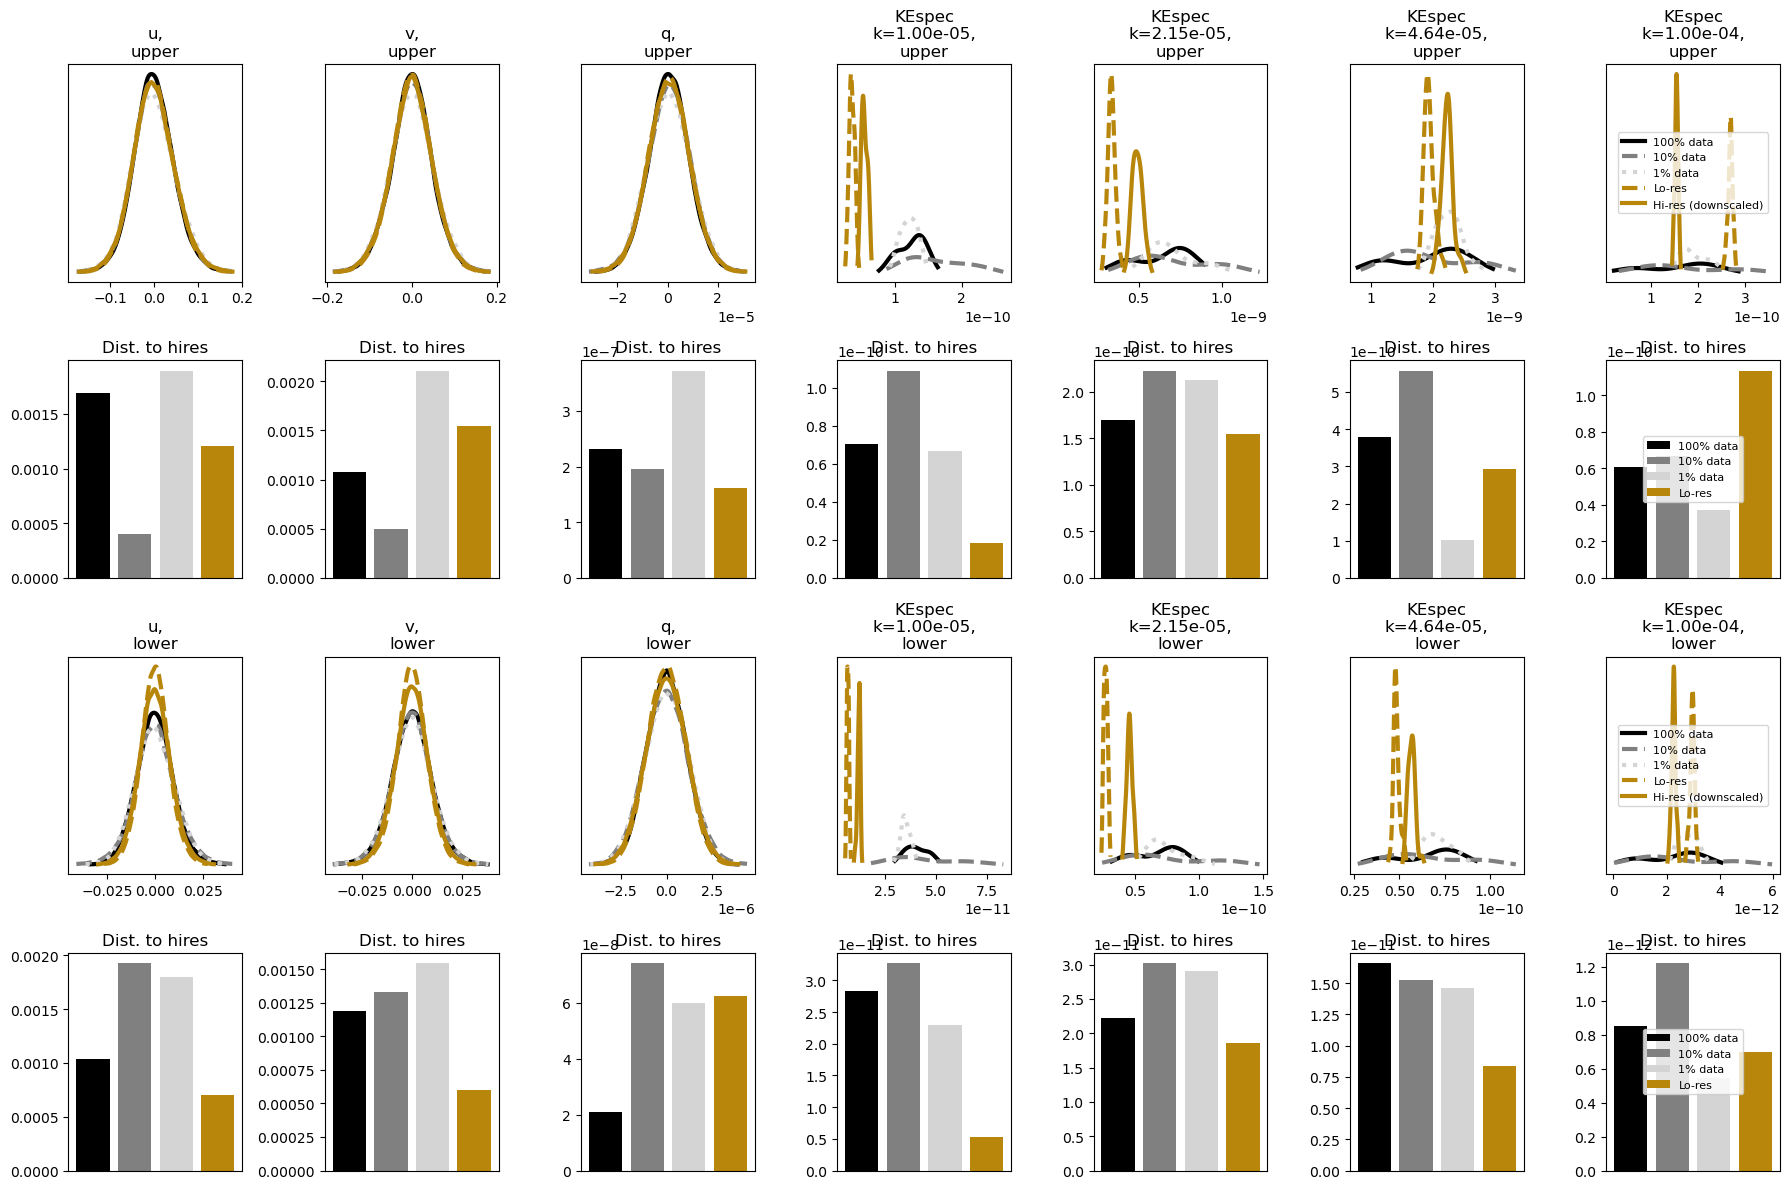

In [90]:
for label, model_opts in comps.items():
    compare_online_performance(label, model_opts)

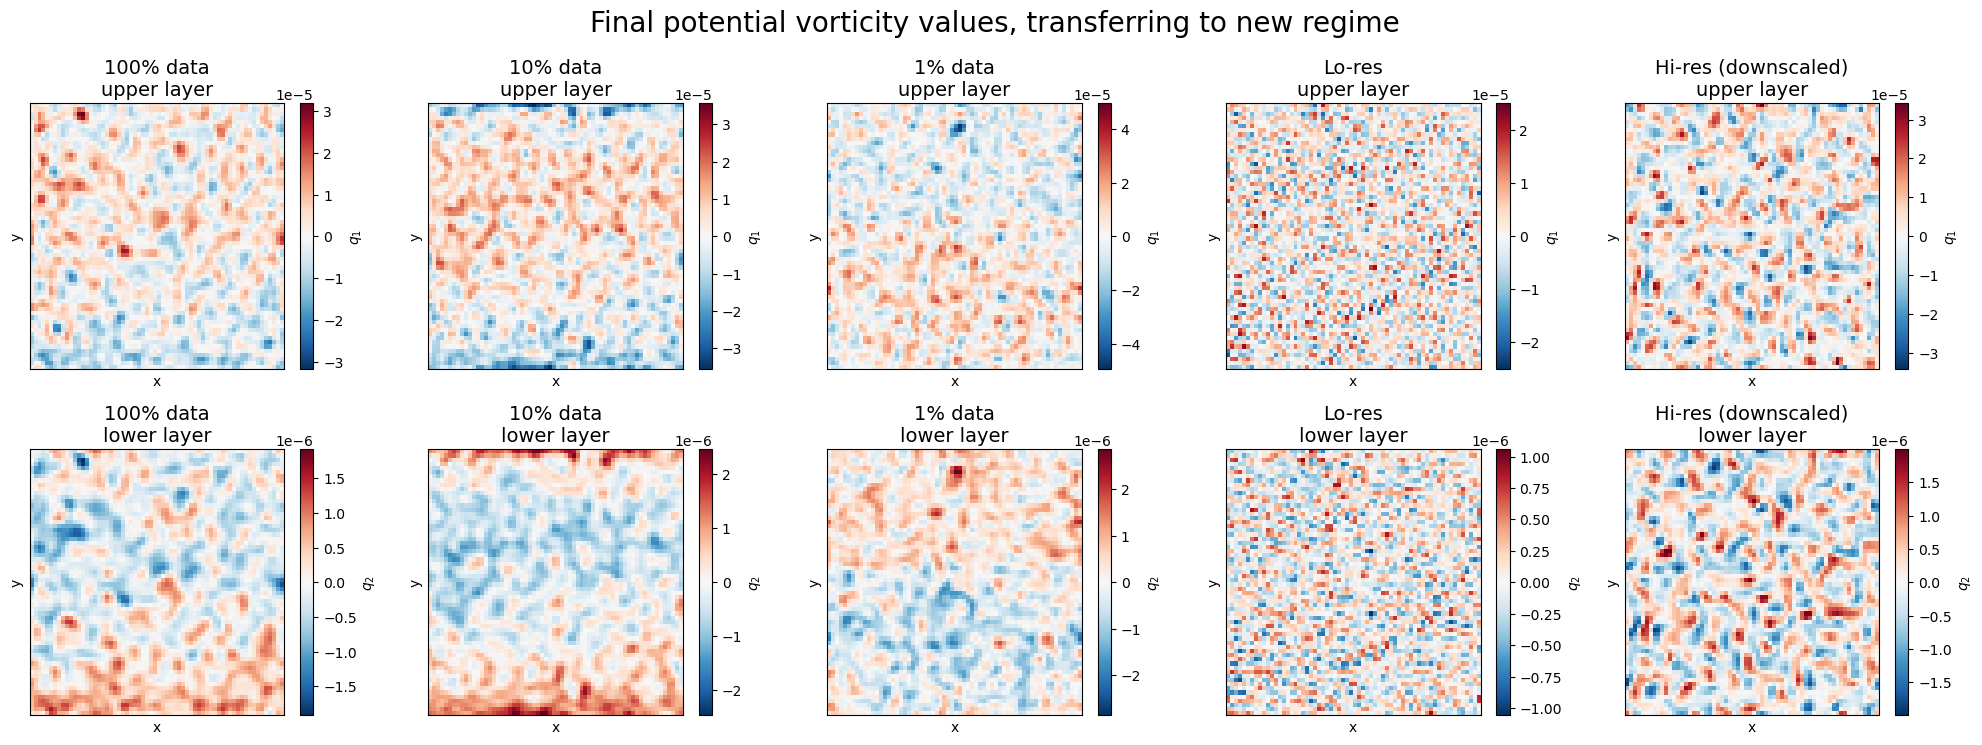

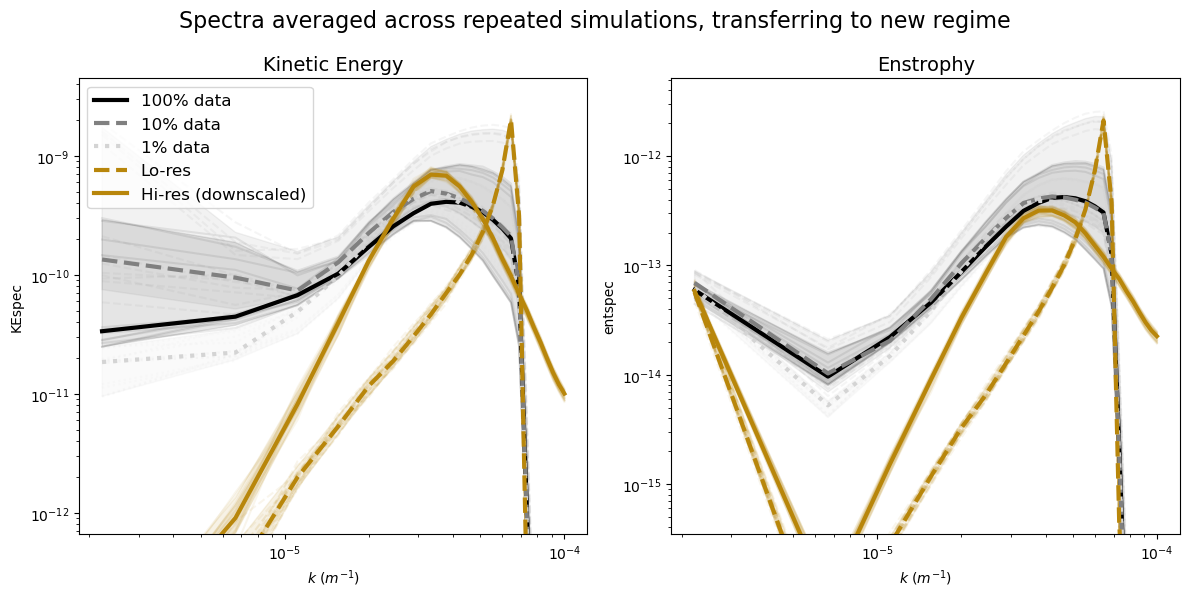

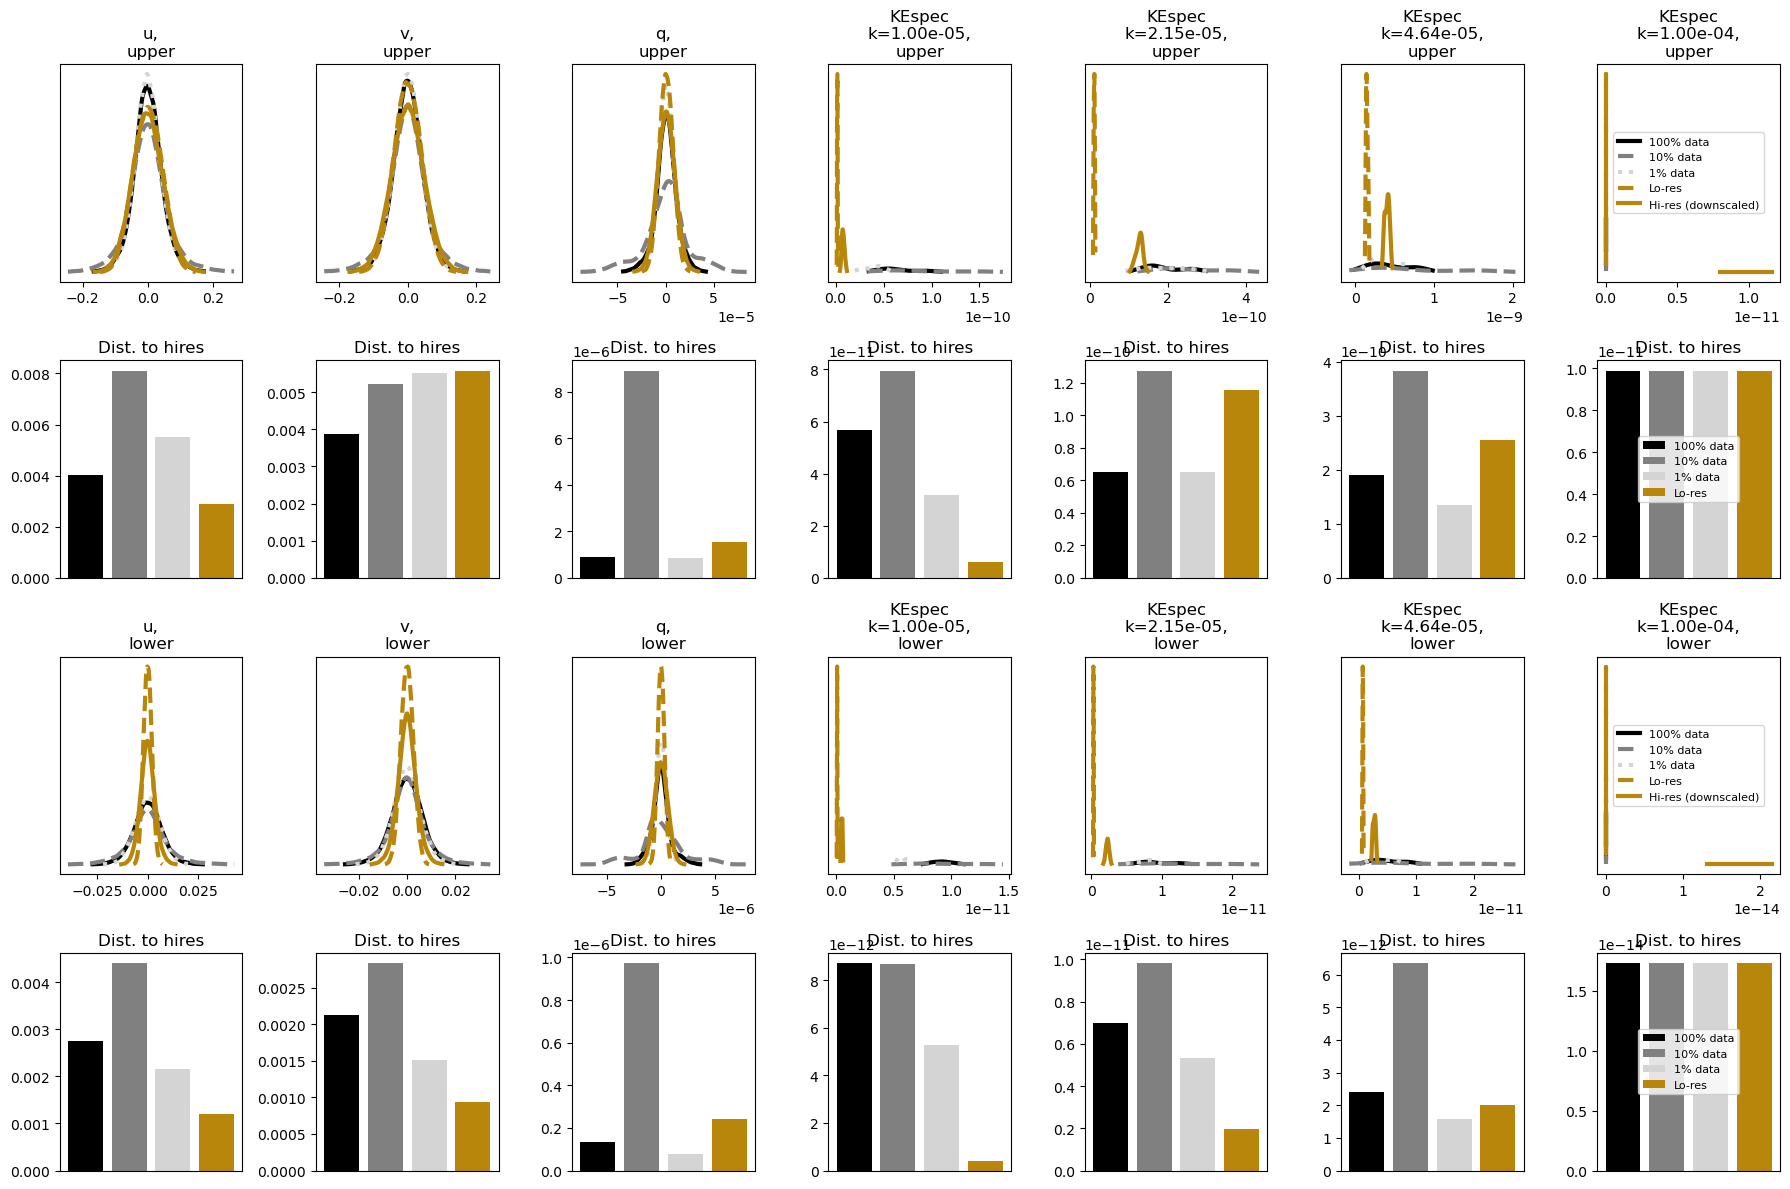

In [91]:
model_opts = comps["different dataset sizes"]
compare_online_performance("transferring to new regime", model_opts, data_dir="/scratch/zanna/data/pyqg/datasets/transfer")

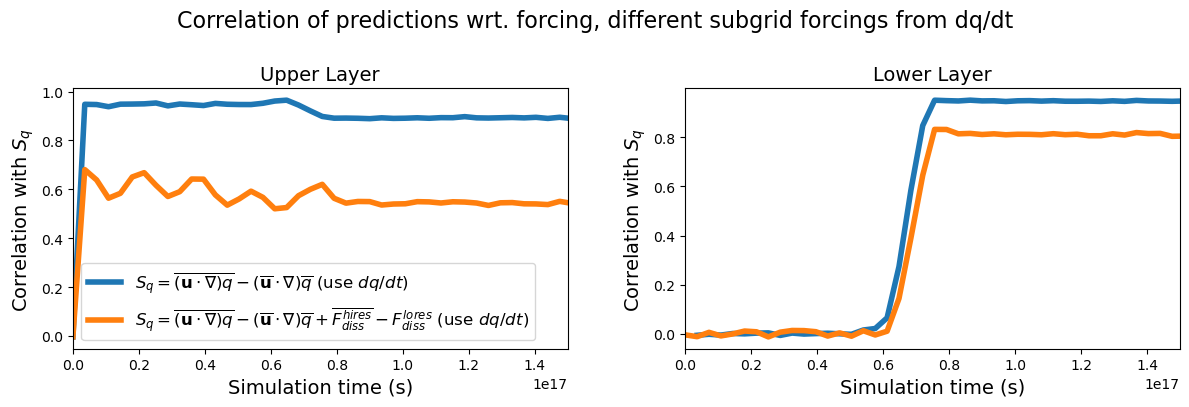

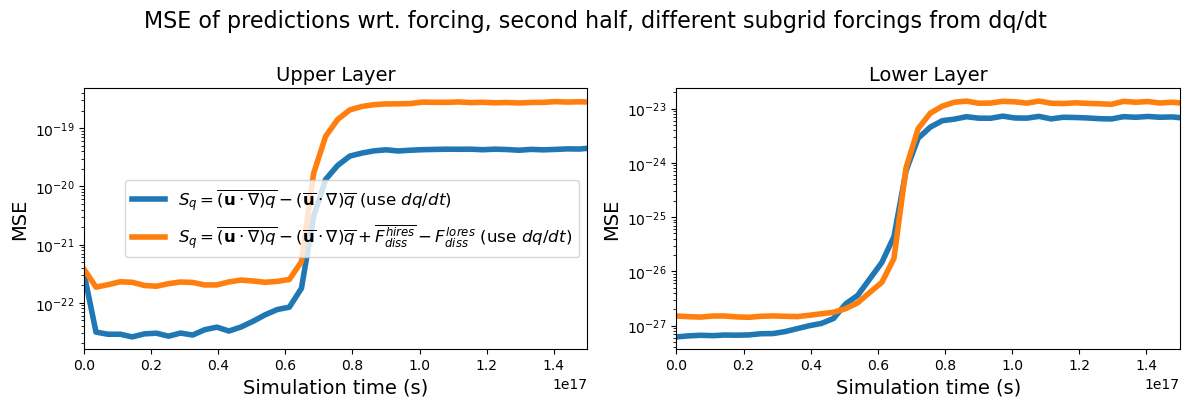

In [92]:
compare_offline_performance("different subgrid forcings from dq/dt", dict(
       fullycnn_dqdt=dict(
           label="$S_q = \\overline{\\left(\\mathbf{u} \\cdot \\nabla\\right)q} - \\left(\\overline{\\mathbf{u}} \\cdot \\nabla\\right)\\overline{q}$ (use $dq/dt$)",
        ),
         fullycnn_dqdt_way2=dict(
            label="$S_q = \\overline{\\left(\\mathbf{u} \\cdot \\nabla\\right)q} - \\left(\\overline{\\mathbf{u}} \\cdot \\nabla\\right)\\overline{q} + \\overline{F_{diss}^{hires}} - F_{diss}^{lores}$ (use $dq/dt$)",
        ),
 ))

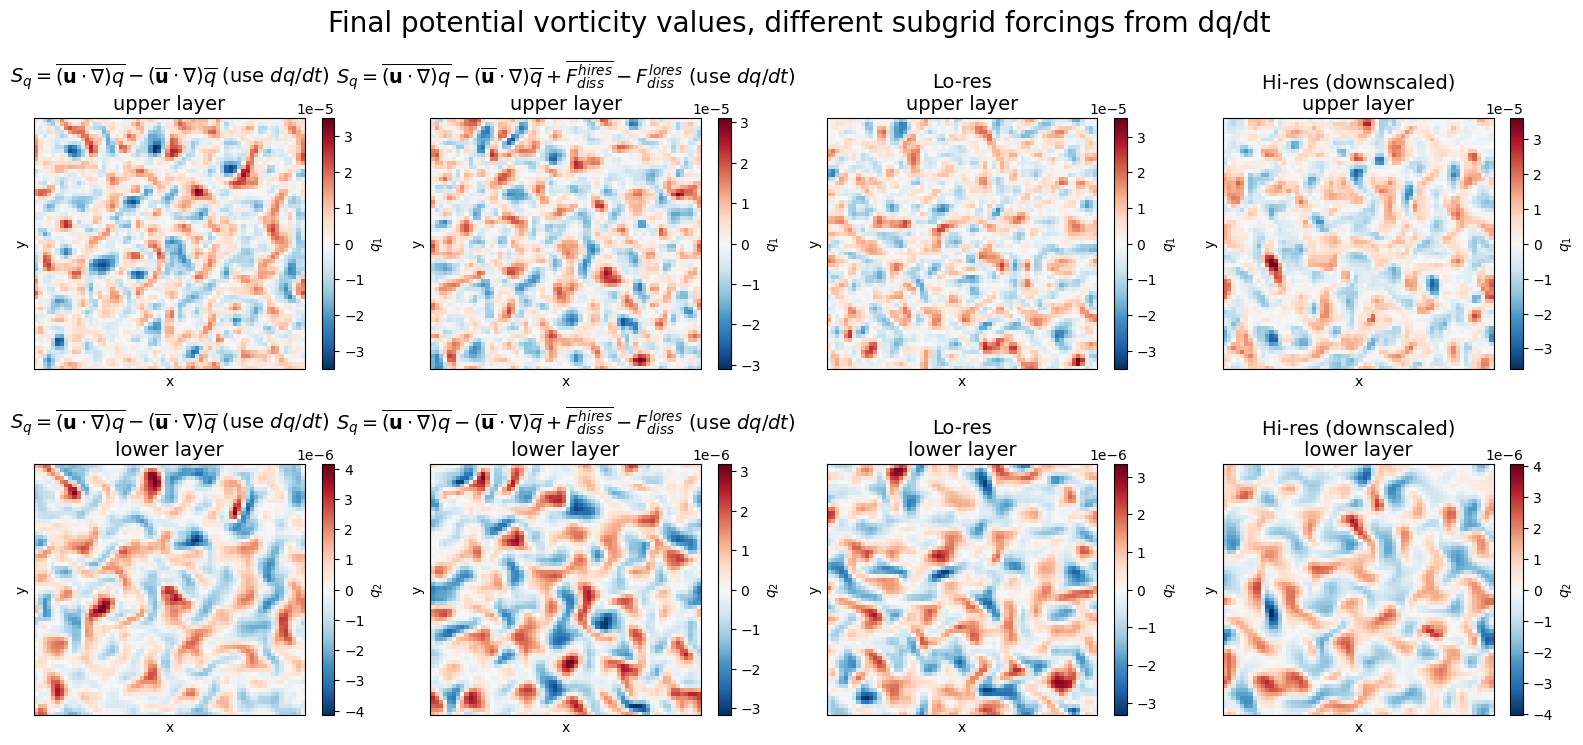

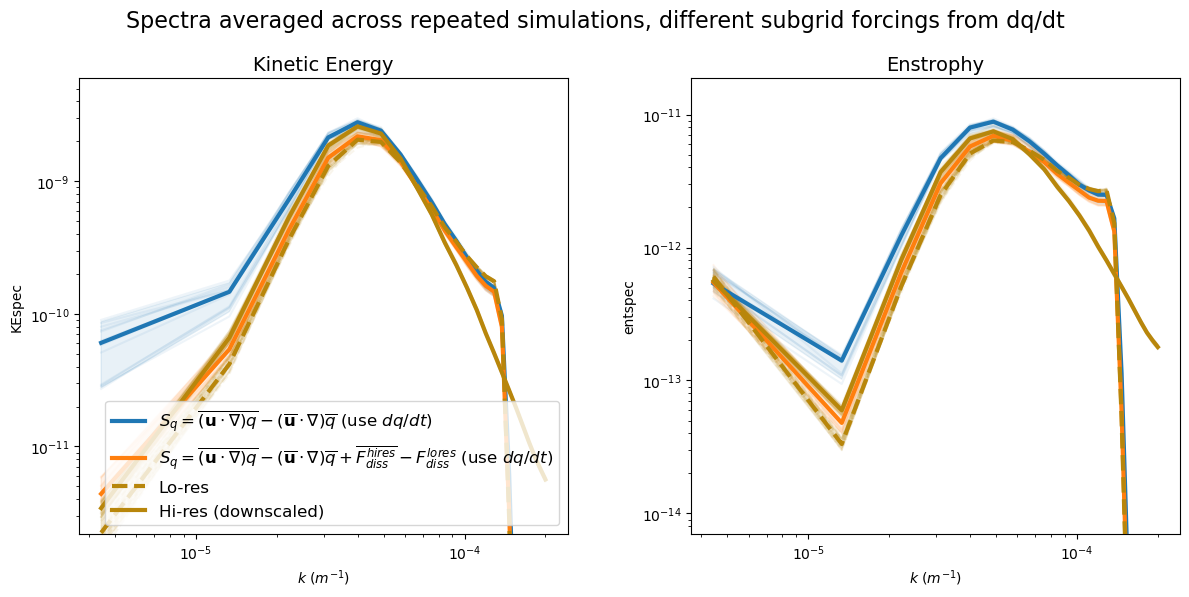

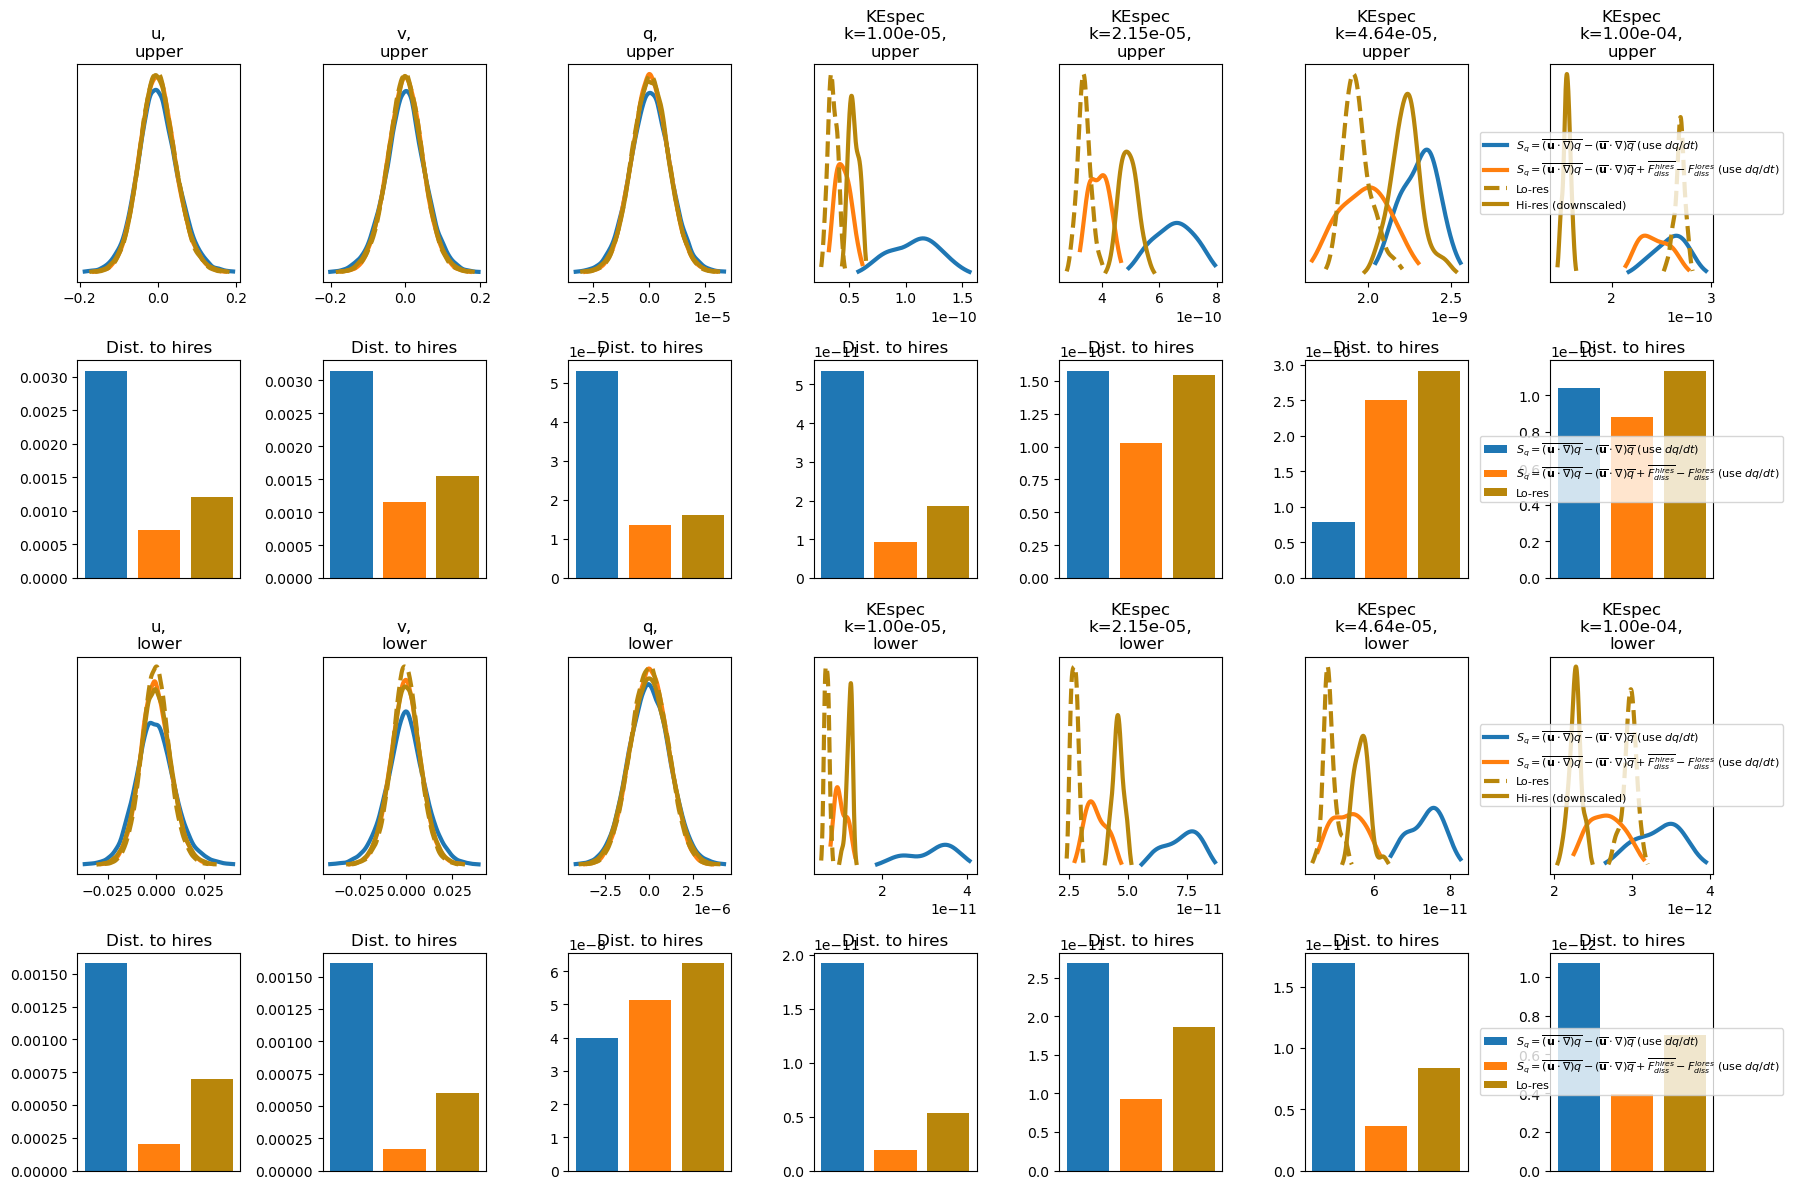

In [93]:
compare_online_performance("different subgrid forcings from dq/dt", dict(
       fullycnn_dqdt=dict(
           label="$S_q = \\overline{\\left(\\mathbf{u} \\cdot \\nabla\\right)q} - \\left(\\overline{\\mathbf{u}} \\cdot \\nabla\\right)\\overline{q}$ (use $dq/dt$)",
        ),
         fullycnn_dqdt_way2=dict(
            label="$S_q = \\overline{\\left(\\mathbf{u} \\cdot \\nabla\\right)q} - \\left(\\overline{\\mathbf{u}} \\cdot \\nabla\\right)\\overline{q} + \\overline{F_{diss}^{hires}} - F_{diss}^{lores}$ (use $dq/dt$)",
        ),
 ))

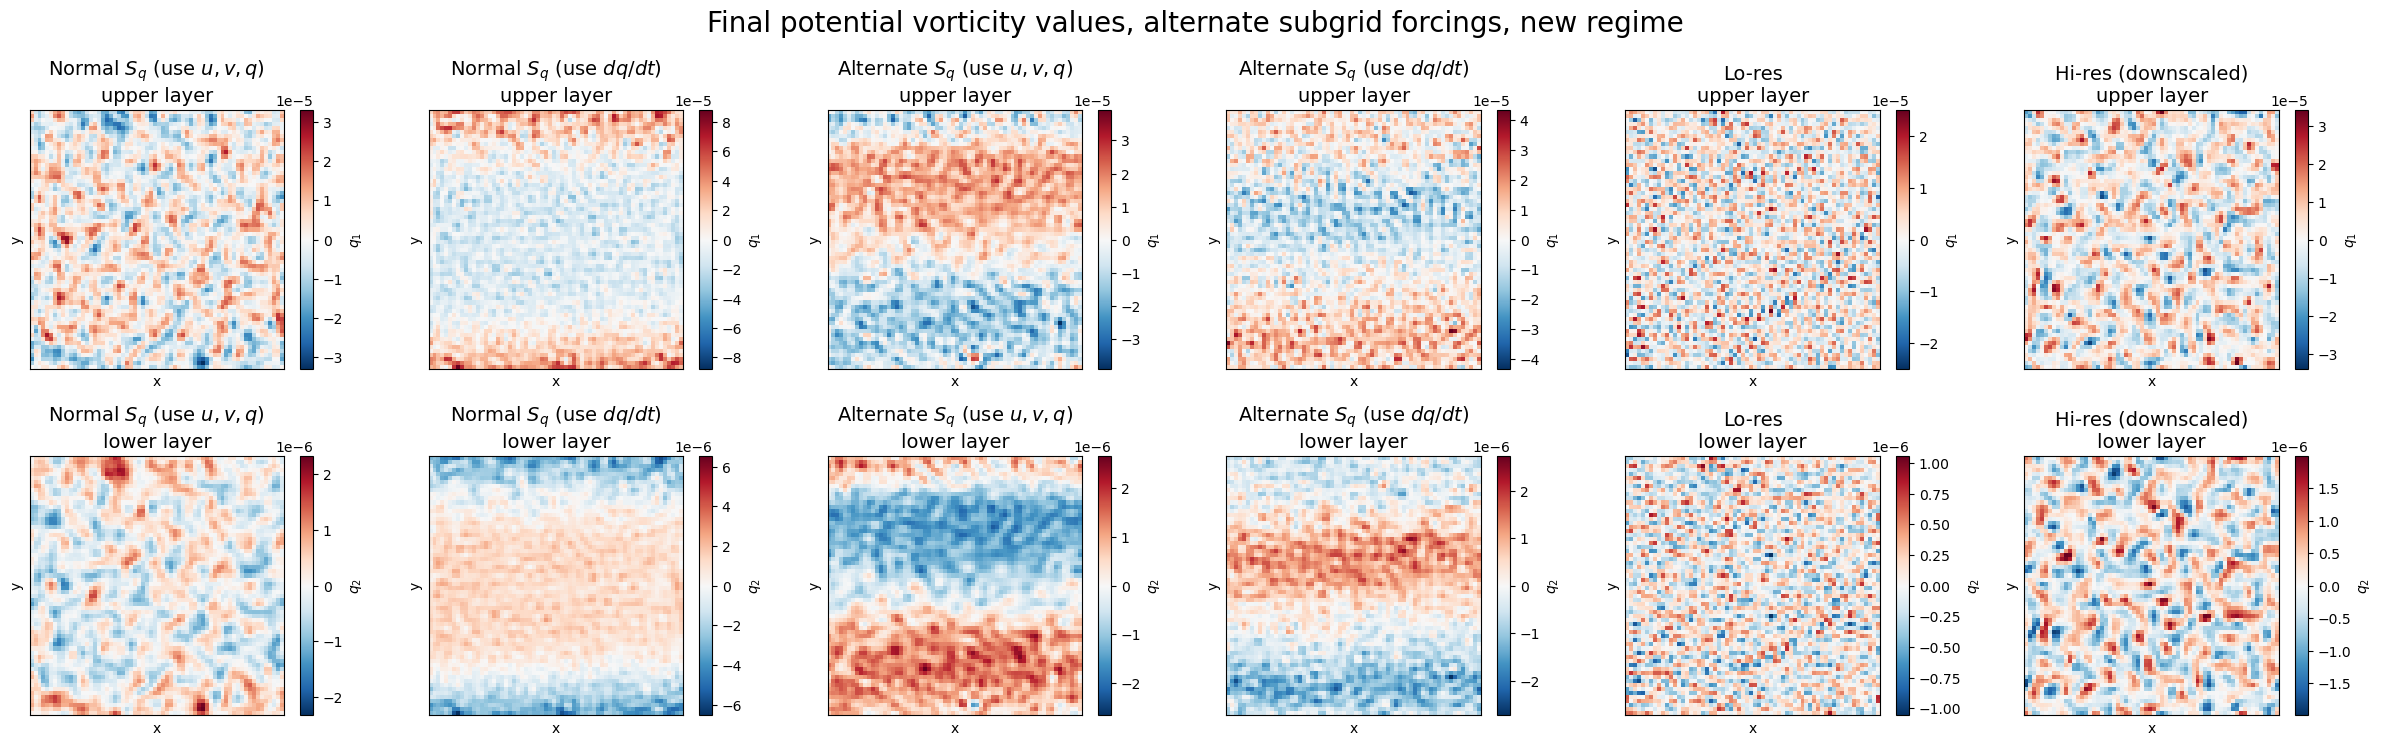

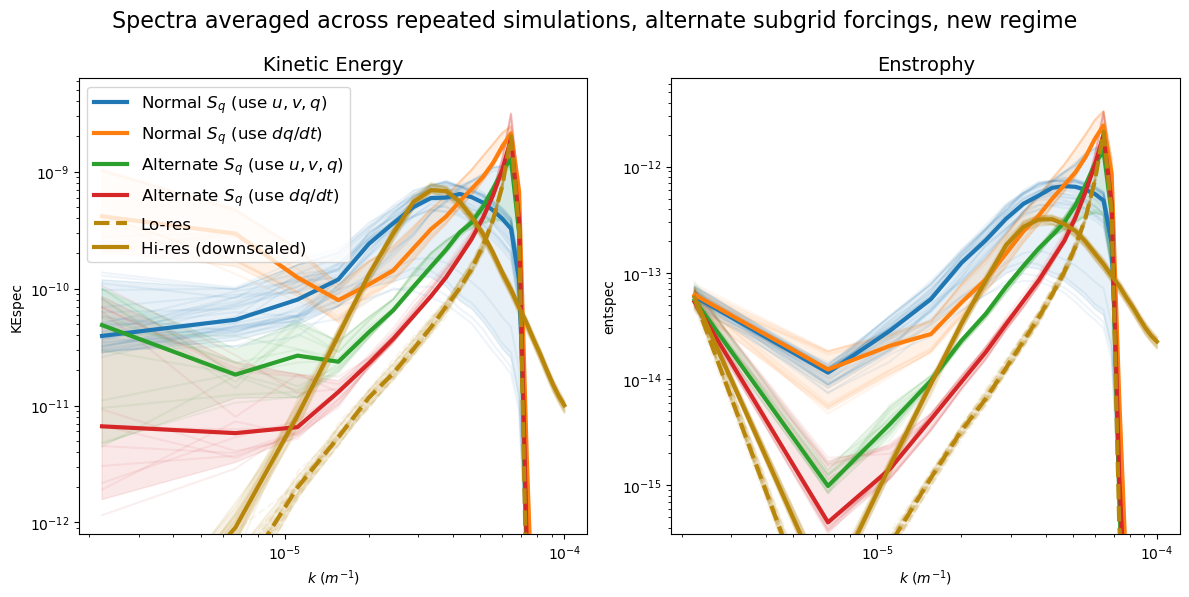

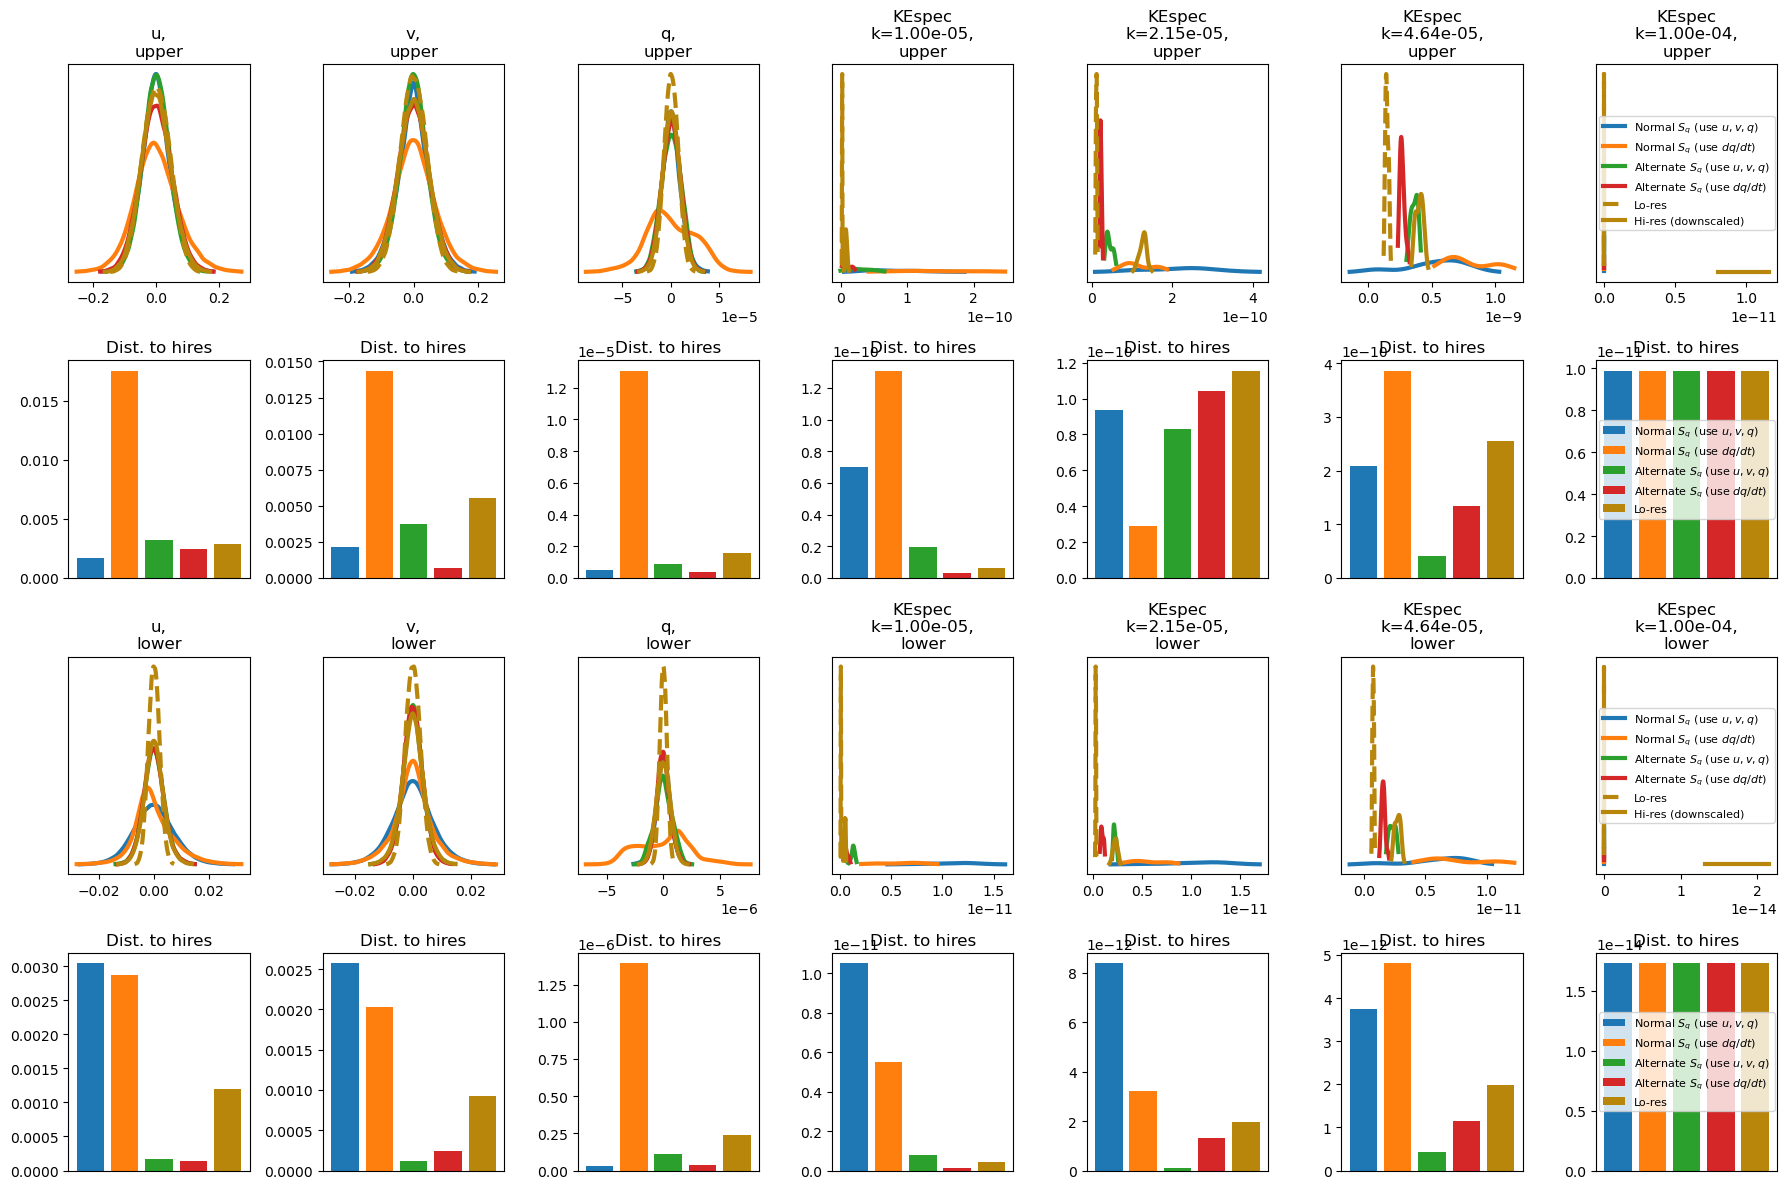

In [94]:
from collections import OrderedDict

compare_online_performance(
    "alternate subgrid forcings, new regime",
    OrderedDict([
        ('fullycnn', dict(
            label="Normal $S_q$ (use $u,v,q$)"
        )),
        ('fullycnn_dqdt', dict(
           label="Normal $S_q$ (use $dq/dt$)",
        )),
        ('fullycnn_way2', dict(
            label="Alternate $S_q$ (use $u,v,q$)",
        )),
        ('fullycnn_dqdt_way2', dict(
            label="Alternate $S_q$ (use $dq/dt$)",
        )),
    ]),
     data_dir="/scratch/zanna/data/pyqg/datasets/transfer"
)

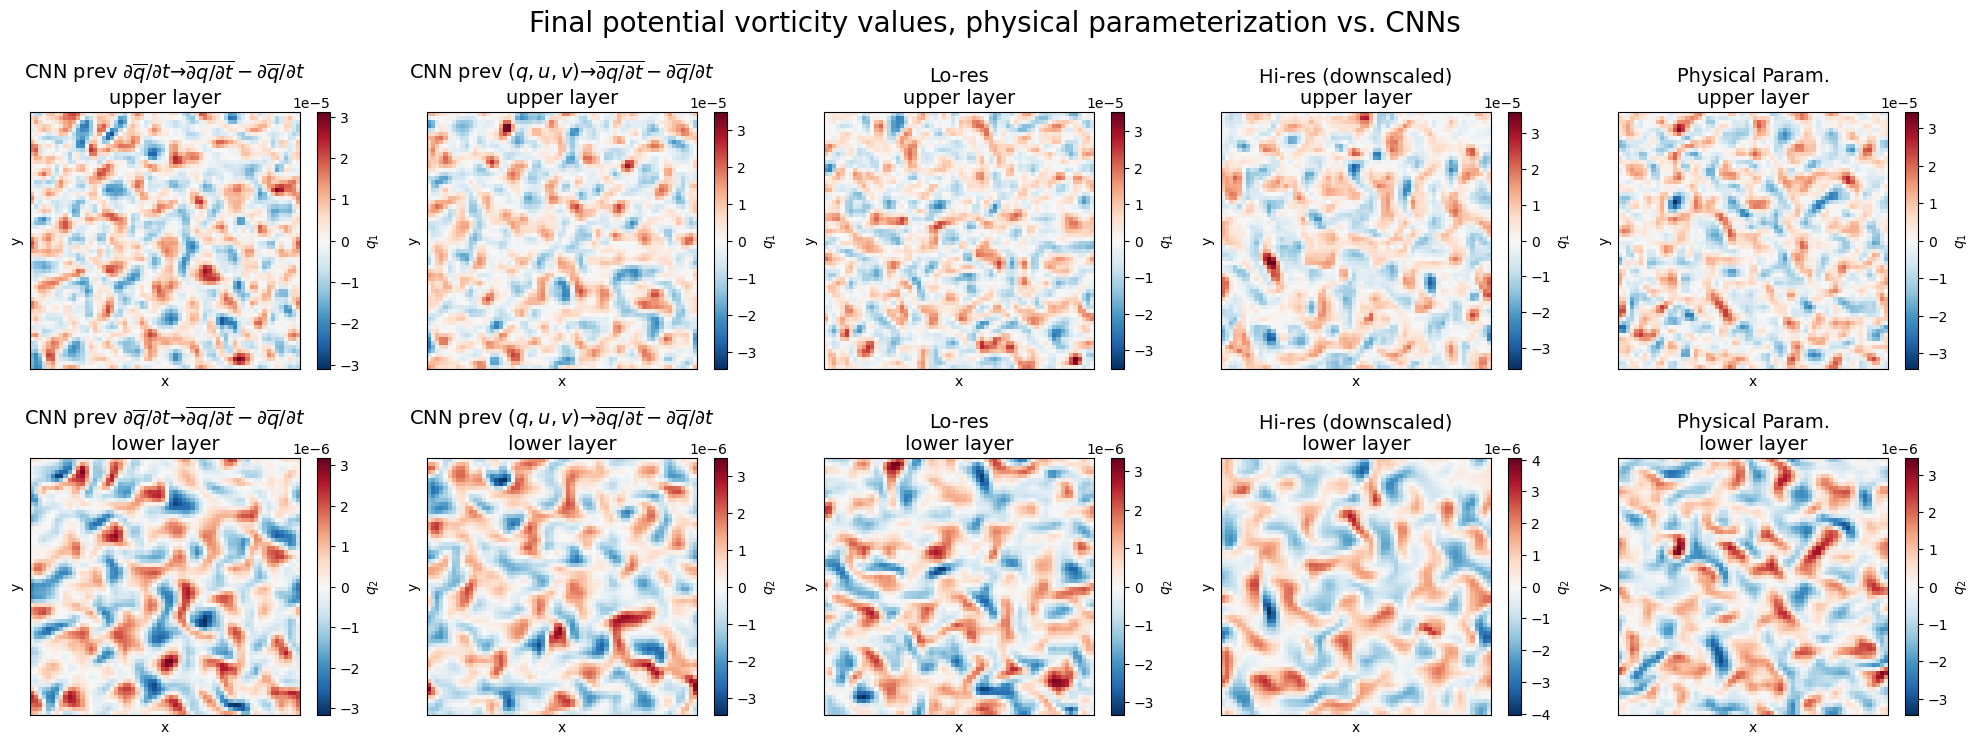

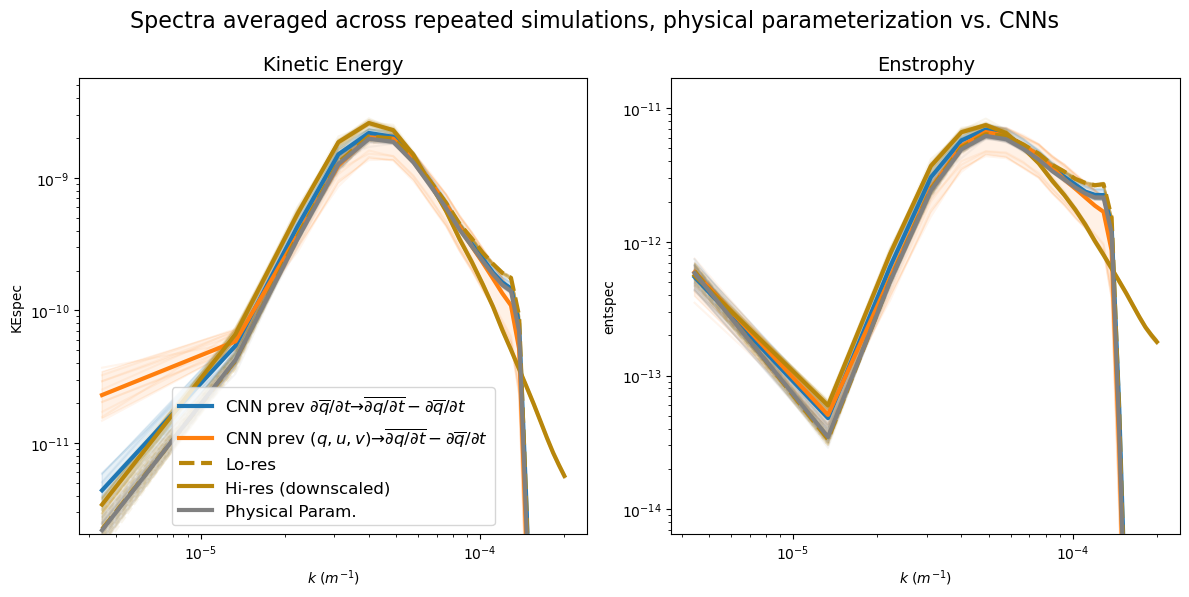

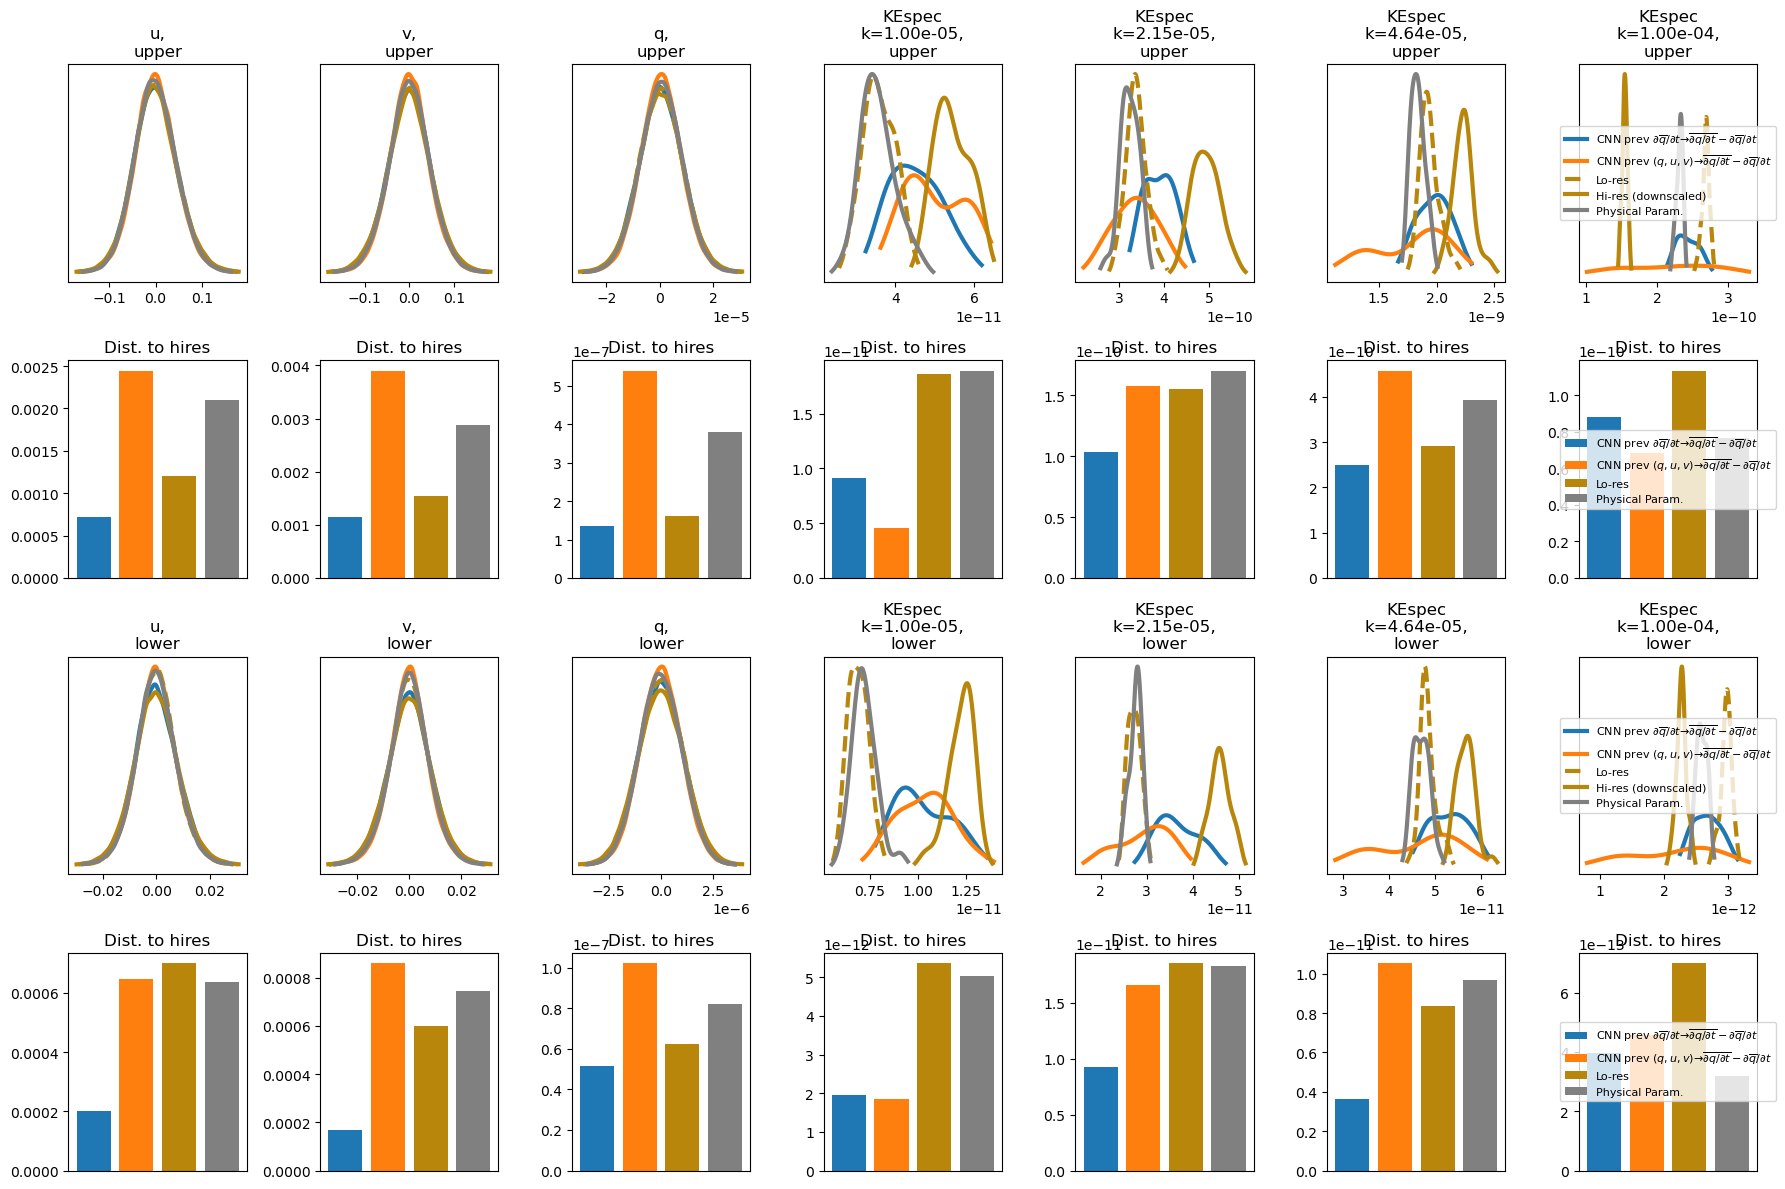

In [95]:
compare_online_performance("physical parameterization vs. CNNs", dict(
  fullycnn_way2=dict(label="CNN prev $(q,u,v) \\to \\overline{\\partial q/\partial t} - \\partial\\overline{q}/\\partial t$"),
  fullycnn_dqdt_way2=dict(label="CNN prev $\\partial \\overline{q}/\\partial t \\to \\overline{\\partial q/\partial t} - \\partial\\overline{q}/\\partial t$"),
), show_physical=True)

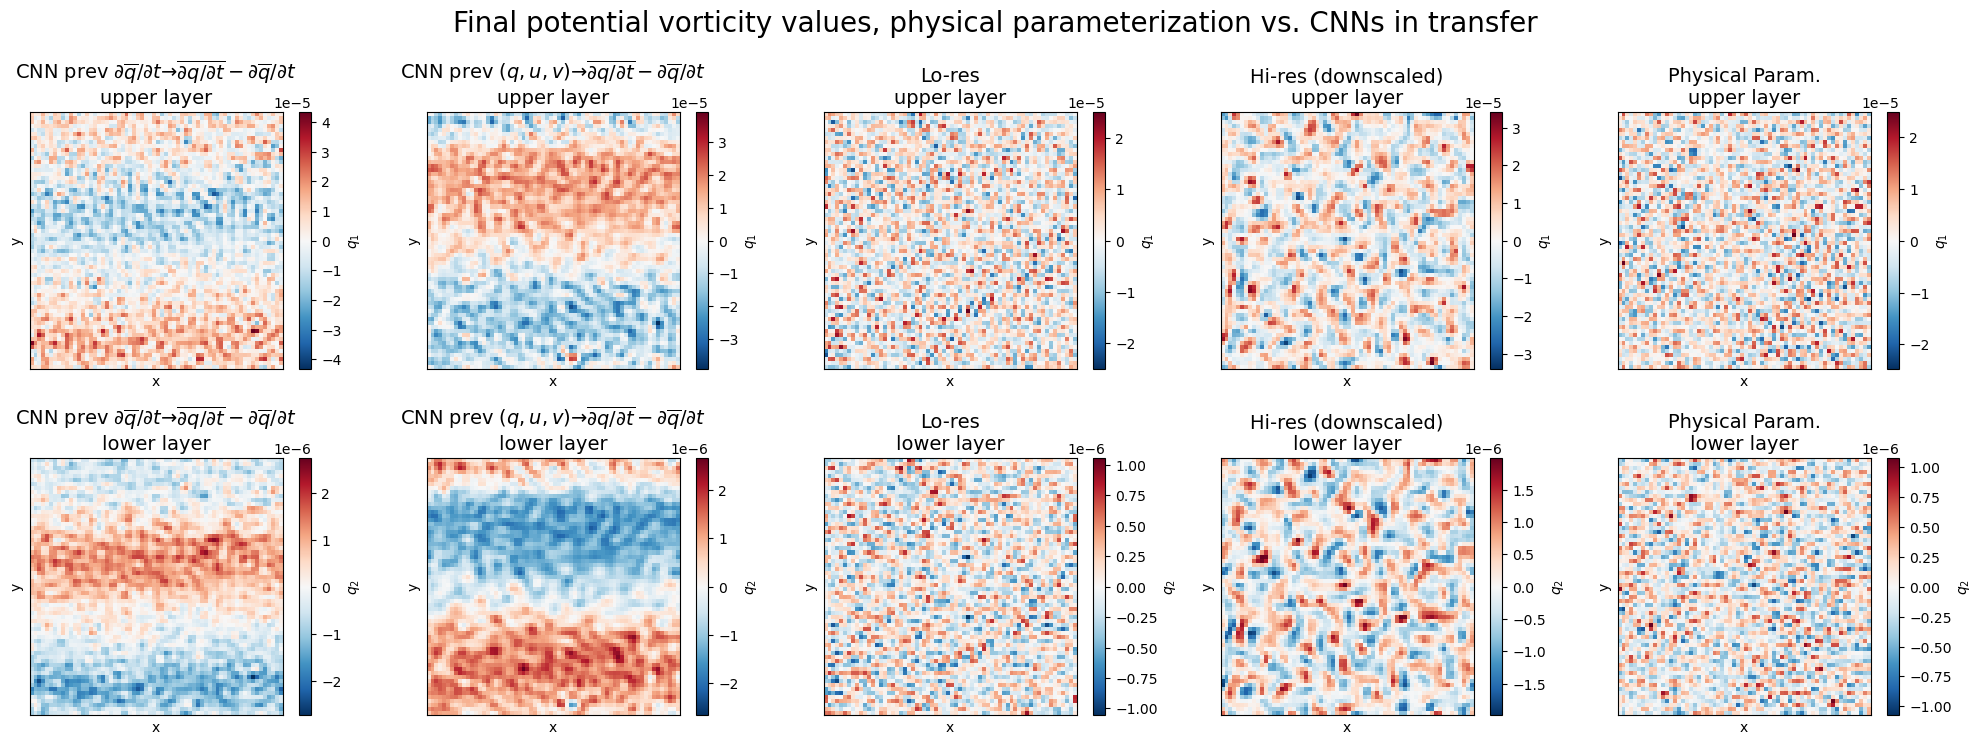

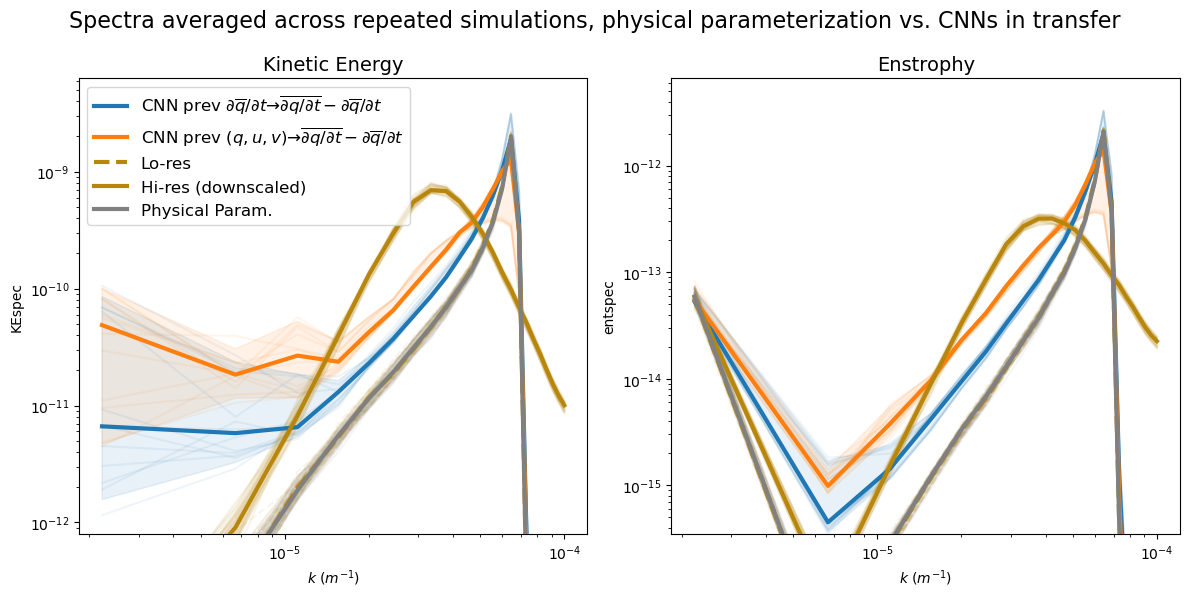

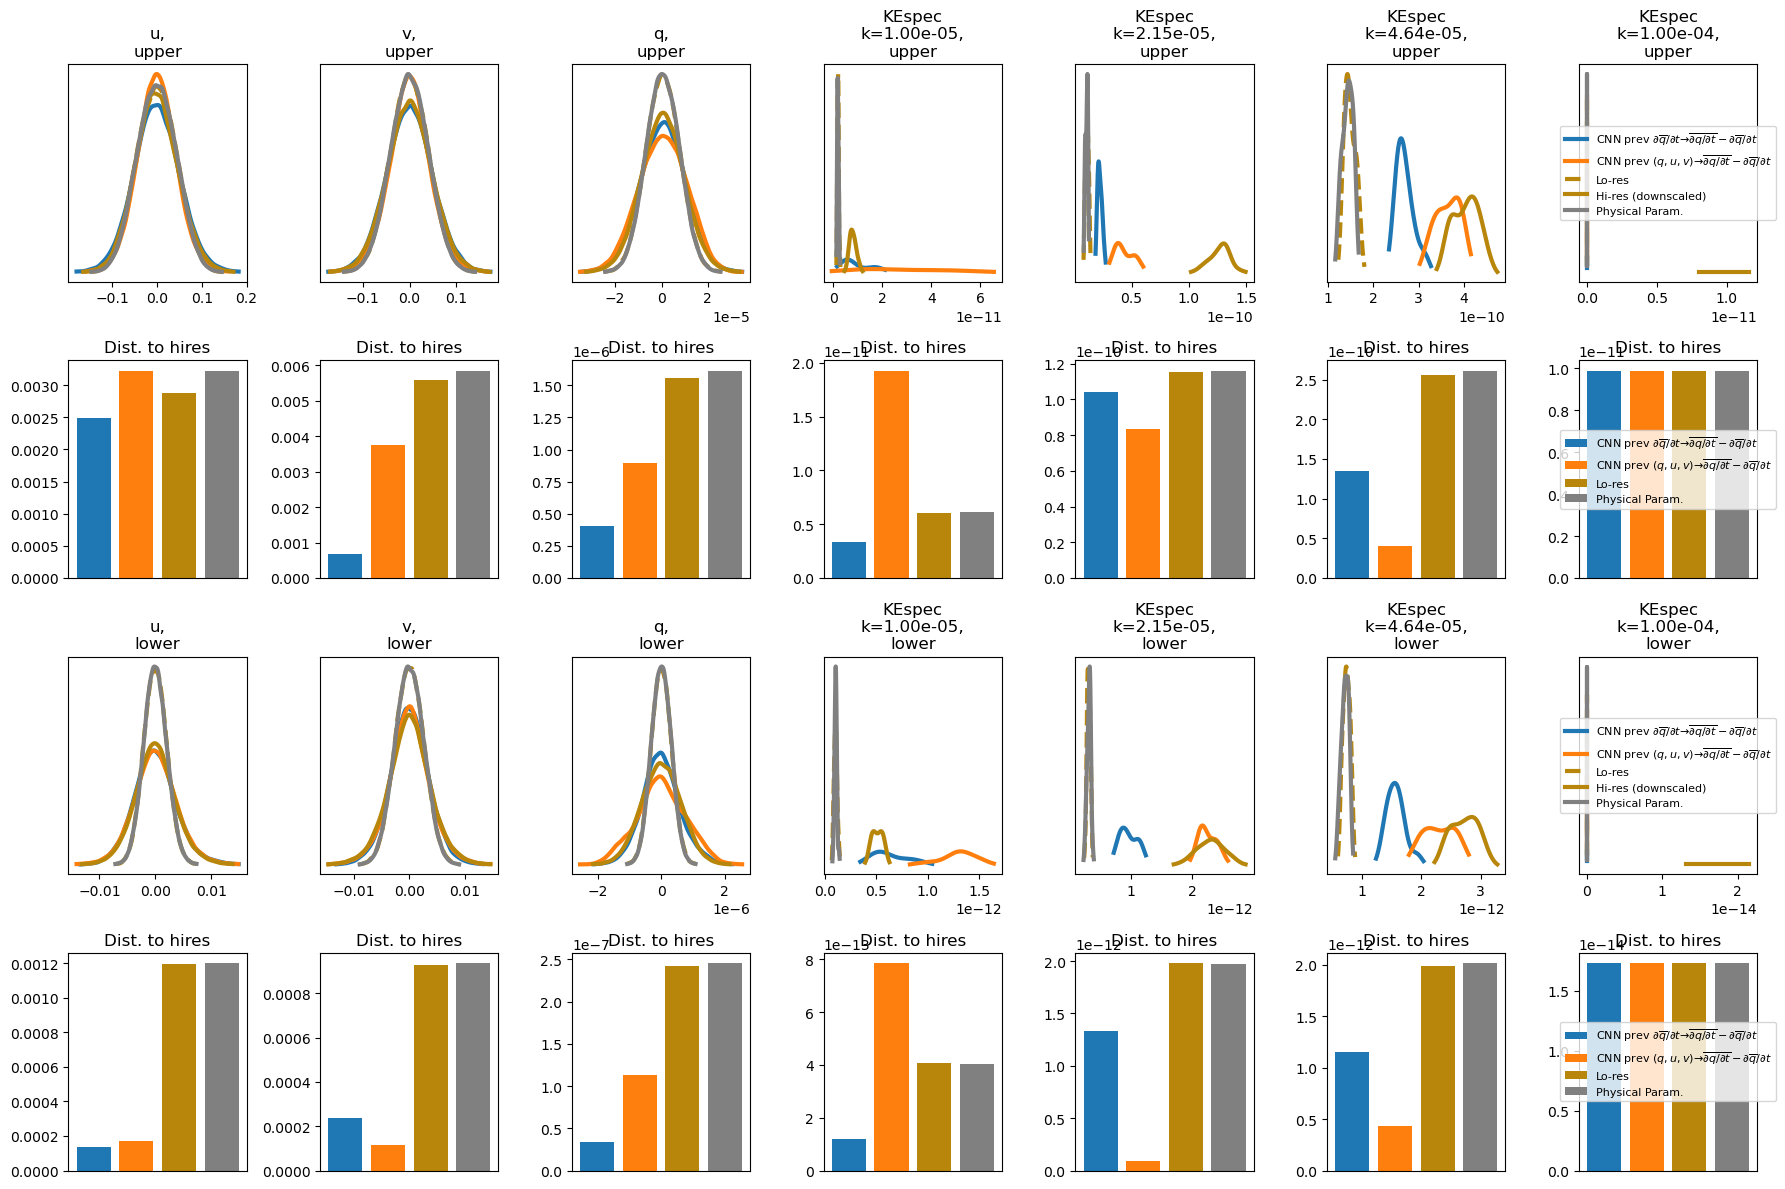

In [96]:
compare_online_performance("physical parameterization vs. CNNs in transfer", dict(
  fullycnn_way2=dict(label="CNN prev $(q,u,v) \\to \\overline{\\partial q/\partial t} - \\partial\\overline{q}/\\partial t$"),
  fullycnn_dqdt_way2=dict(label="CNN prev $\\partial \\overline{q}/\\partial t \\to \\overline{\\partial q/\partial t} - \\partial\\overline{q}/\\partial t$"),
), show_physical=True,
data_dir="/scratch/zanna/data/pyqg/datasets/transfer")